In [356]:
import pymc3 as pm
from sklearn.decomposition import PCA
import pandas as pd
from time import time
from sklearn.cluster import KMeans

In [357]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [358]:
from scGeneFit.functions import *

import numpy as np
np.random.seed(0) 
from sklearn.preprocessing import normalize

In [359]:
import theano

## Marker Gene Selection

MAGE-SELECT is a multilevel bayesian logitic regression algorithm for identifying marker genes. The cell below creates the bayesian model using PyMC3. Below that you will find the function which allows you to find marker genes for all cell types of the two datasets we have functionality for. Enjoy!

In [361]:
def get_bayes_markers(obs,inp,flevel,mgenes,testing=False):
    '''
    obs: observed Y values
    inp: Input X data, # of cells * # of marker gene candidates
    flevel: The meta-cluster values
    mgenes: (k) number of marker genes being tests
    testing: If we are doing speed testing

    output: an array of 
    '''
    basic_model = pm.Model()
    with basic_model:
        #priors for random intercept
        mu_a = pm.Normal('mu_a', mu=0., sigma=2)
        sigma_a = pm.HalfNormal('sigma_a', 1)
        # Intercept for each cluster, distributed around group mean mu_a
        # Above we just set mu and sd to a fixed value while here we
        # plug in a common group distribution for all a and b (which are
        # vectors of length n_counties).
        num_levels = len(np.unique(flevel))
        
        #for speed testing
        if testing:
            alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a,shape = 8)
        else:
            alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a,shape = num_levels)

        # Priors for unknown model parameters
        #beta = pm.Beta("beta", alpha=1/2, beta = 1/2, shape=20)
        beta = pm.Laplace("beta", mu=0, b = 1, shape=mgenes)
        #beta = pm.Normal("beta", mu=0, sigma = 0.5, shape=30)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Bernoulli("Y_obs", logit_p=alpha[flevel] + inp @ beta, observed=obs)
        
        #map_estimate = pm.find_MAP(model=basic_model)
        #map_betas = np.where(map_estimate['beta'] > 0)[0]
        #print(map_betas)
    
    with basic_model:
        # draw 200 posterior samples
        trace = pm.sample(200)
    
    
    df = az.summary(trace, round_to=2)
    #print(df)
    betas = df.iloc[9:-1,:]
    #betas with significant values
    sample_betas = betas[betas["hpd_3%"] > 0].index.values
    
    #return the actual number (1,mgenes) of the genes that were significant
    offset = num_levels
    beta_values =  np.where(df.index.isin(sample_betas))[0] - offset
    print(beta_values)
    return beta_values

In [352]:
def marker_results(cite_seq,num_mgenes):
    '''
    cite_seq: boolean, are we using citseq data (otherwise us zeisel)
    num_genes: number of marker genes candidates to test
    
    output:
    sample_betas: an array of size # of cell types, of numpy arrays, which contain the betas for that cell type 
                    corresponding to the marker genes identified for that cell type 
    '''
    if cite_seq:
        [data, labels, names]= load_example_data("CITEseq")
        
        #meta clusters
        kmeans = KMeans(n_clusters=8, random_state=42).fit(data)
        flevel = kmeans.labels_
        
    else:
        [data, labels, names]= load_example_data("zeisel")
        
         #meta clusters
        kmeans = KMeans(n_clusters=4, random_state=42).fit(data)
        flevel = kmeans.labels_
                
    #only take genes with highest variance
    var = normalize(data, norm="l1").var(axis = 0)
    ind = np.argpartition(var, -num_mgenes)[-num_mgenes:]
    inp = normalize(data, norm="l1")[:,ind] * 1000

    sample_betas = []
    
    #correction for zeisel data
    if not cite_seq:
        labels = labels[0]
    #regression for each cell type (m)
    for lab in np.unique(labels):
        obs = np.array(labels == lab).astype(int)
        sb = get_bayes_markers(obs,inp,flevel,num_mgenes)
        sample_betas.append(sb)
        print("Got marker genes for cell type {}".format(lab))
        
    return sample_betas
    

The cell below calls the marker results function for varying values of k. It will take some time to run. The results will be an array of arrays. Each subarray contains the marker genes for cell type i.

In [186]:
citeseq_betas_20 = marker_results(True,20)
citeseq_betas_25 = marker_results(True,25)
citeseq_betas_30 = marker_results(True,30)

zeisel_betas_10 = marker_results(False,10)
zeisel_betas_20 = marker_results(False,20)
zeisel_betas_25 = marker_results(False,25)
zeisel_betas_30 = marker_results(False,30)


logp = -88.761, ||grad|| = 2,239: 100%|██████████| 402/402 [00:00<00:00, 484.12it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:13<00:00, 19.07draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -2.07  1.17   -3.90     0.18       0.11     0.08    116.18  116.18   
alpha[0] -0.57  1.43   -3.05     2.16       0.12     0.09    137.52  137.52   
alpha[1] -1.37  1.43   -3.93     1.24       0.11     0.08    182.92  177.87   
alpha[2] -2.22  1.96   -6.24     0.94       0.16     0.11    156.18  156.18   
alpha[3] -3.29  1.50   -5.77    -0.05       0.11     0.08    170.12  170.12   
alpha[4] -3.44  1.02   -5.29    -1.54       0.10     0.07    114.96  114.96   
alpha[5] -1.80  1.83   -5.22     1.40       0.15     0.10    156.60  156.60   
alpha[6] -2.47  0.89   -3.93    -0.51       0.09     0.06    102.51  102.51   
alpha[7] -2.32  1.93   -5.60     1.90       0.13     0.09    225.95  225.95   
beta[0]   2.05  0.18    1.76     2.45       0.01     0.01    376.48  369.93   
beta[1]  -0.20  0.13   -0.44     0.04       0.01     0.01    273.47  260.64   
beta[2]  -1.18  0.24   -1.62    -0.75       0.01    

logp = -706.53, ||grad|| = 6.75e+05: 100%|██████████| 641/641 [00:01<00:00, 479.50it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:23<00:00, 16.85draws/s]
The acceptance probability does not match the target. It is 0.881744190774656, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.44  0.56   -5.61    -3.42       0.04     0.03    164.60  156.80   
alpha[0] -4.93  0.90   -6.59    -3.28       0.06     0.05    189.85  184.25   
alpha[1] -3.75  0.43   -4.52    -2.92       0.03     0.02    164.46  164.46   
alpha[2] -4.71  1.03   -6.83    -3.00       0.07     0.05    188.33  176.85   
alpha[3] -4.68  0.95   -6.74    -3.18       0.06     0.04    238.83  234.00   
alpha[4] -4.56  0.73   -5.80    -3.10       0.05     0.04    210.95  210.95   
alpha[5] -4.69  0.58   -5.79    -3.60       0.05     0.03    161.68  161.68   
alpha[6] -4.37  0.38   -5.08    -3.61       0.03     0.02    181.65  181.65   
alpha[7] -4.73  0.94   -6.47    -2.99       0.06     0.04    229.65  219.97   
beta[0]   0.13  0.05    0.04     0.23       0.00     0.00    481.04  348.20   
beta[1]  -0.83  0.08   -0.99    -0.67       0.00     0.00    441.96  427.23   
beta[2]   0.19  0.07    0.07     0.32       0.00    

logp = -278.32, ||grad|| = 1.5033: 100%|██████████| 526/526 [00:00<00:00, 688.46it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:24<00:00, 16.62draws/s]
The acceptance probability does not match the target. It is 0.895920574844257, but should be close to 0.8. Try to increase the number of tuning steps.


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -6.35  1.50   -9.11    -3.59       0.08     0.05    399.92  385.73   
alpha[0] -11.25  2.25  -15.98    -7.42       0.11     0.08    387.14  364.90   
alpha[1]  -1.90  0.88   -3.69    -0.36       0.05     0.04    261.91  249.44   
alpha[2]  -7.23  3.75  -13.58     0.36       0.18     0.15    457.79  301.68   
alpha[3] -17.60  2.37  -22.01   -13.24       0.16     0.12    207.46  201.90   
alpha[4] -10.75  2.30  -15.14    -7.04       0.18     0.13    166.16  155.95   
alpha[5]  -4.15  1.37   -6.71    -1.68       0.07     0.05    356.87  326.19   
alpha[6] -12.45  1.14  -14.38   -10.10       0.07     0.05    304.37  300.68   
alpha[7]  -7.71  3.52  -14.50    -0.87       0.18     0.13    368.58  368.58   
beta[0]   -0.24  0.11   -0.44    -0.04       0.00     0.00    504.80  504.80   
beta[1]    0.14  0.13   -0.10     0.37       0.01     0.01    418.20  326.06   
beta[2]    0.05  0.13   -0.20     0.28  

logp = -109.96, ||grad|| = 1.4017: 100%|██████████| 206/206 [00:00<00:00, 765.67it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:17<00:00, 18.08draws/s]


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a       0.80  1.85   -2.65     4.05       0.11     0.09    260.98  234.94   
alpha[0]  -3.71  3.03   -9.84     1.54       0.17     0.13    322.08  277.27   
alpha[1]   0.77  4.26   -7.85     8.08       0.23     0.19    330.81  247.11   
alpha[2]   0.66  4.35   -6.48     8.95       0.22     0.22    385.54  190.81   
alpha[3]   0.29  4.40   -8.21     8.08       0.27     0.22    272.74  195.71   
alpha[4]  14.74  2.30   10.13    18.73       0.16     0.12    203.13  178.99   
alpha[5]   0.52  4.14   -7.29     7.69       0.24     0.21    292.20  194.93   
alpha[6]  -5.12  2.20   -9.97    -1.64       0.15     0.11    222.99  192.38   
alpha[7]   0.81  4.57   -7.98     9.10       0.23     0.23    405.38  198.15   
beta[0]    0.02  0.13   -0.21     0.26       0.01     0.01    394.81  238.66   
beta[1]   -2.10  0.33   -2.77    -1.53       0.03     0.02    163.90  152.34   
beta[2]   -0.08  0.22   -0.50     0.36  

logp = -1,129.4, ||grad|| = 0.88986: 100%|██████████| 205/205 [00:00<00:00, 593.10it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:02<00:00, 22.29draws/s]
The acceptance probability does not match the target. It is 0.8787264180343157, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.33  1.01   -2.05     1.68       0.06     0.04    317.79  280.75   
alpha[0] -1.89  1.69   -5.20     1.33       0.08     0.06    397.16  346.96   
alpha[1] -1.44  1.81   -5.32     1.06       0.09     0.09    381.56  196.90   
alpha[2] -0.41  2.24   -4.30     3.82       0.12     0.10    364.32  258.49   
alpha[3] -0.29  0.85   -1.96     1.29       0.05     0.04    352.81  273.90   
alpha[4] -1.94  1.07   -3.97    -0.14       0.05     0.05    393.56  232.97   
alpha[5] -0.73  2.22   -4.79     3.08       0.11     0.11    408.18  196.50   
alpha[6]  4.88  0.33    4.28     5.57       0.02     0.01    405.65  405.65   
alpha[7] -1.32  2.10   -4.61     2.89       0.12     0.10    291.01  240.54   
beta[0]  -0.43  0.07   -0.57    -0.31       0.00     0.00    847.52  784.59   
beta[1]  -0.31  0.04   -0.40    -0.25       0.00     0.00    591.39  533.28   
beta[2]  -0.13  0.09   -0.29     0.03       0.00    

logp = -976.9, ||grad|| = 0.089626: 100%|██████████| 432/432 [00:00<00:00, 457.41it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:45<00:00, 30.95draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.81  1.01   -6.53    -2.57       0.06     0.04    308.32  307.27   
alpha[0] -6.44  1.65   -8.94    -2.97       0.09     0.06    367.32  336.05   
alpha[1] -6.61  1.65   -9.37    -3.67       0.10     0.07    291.08  261.68   
alpha[2] -5.32  2.32   -9.45    -0.48       0.12     0.10    367.63  281.13   
alpha[3] -8.60  1.09  -10.71    -6.75       0.07     0.05    277.68  267.85   
alpha[4] -2.55  0.49   -3.38    -1.60       0.03     0.02    301.85  299.58   
alpha[5] -6.68  1.82   -9.83    -3.14       0.10     0.07    353.25  315.87   
alpha[6] -2.90  0.37   -3.56    -2.22       0.02     0.02    286.17  286.17   
alpha[7] -4.88  2.26   -9.33    -0.83       0.12     0.08    377.59  355.64   
beta[0]  -0.24  0.08   -0.37    -0.07       0.00     0.00    515.69  486.90   
beta[1]   0.30  0.04    0.21     0.37       0.00     0.00    308.30  308.30   
beta[2]  -0.16  0.11   -0.38     0.01       0.00    

logp = -108.59, ||grad|| = 2.0416: 100%|██████████| 312/312 [00:00<00:00, 576.73it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:25<00:00,  9.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -1.73  1.55   -4.44     1.17       0.16     0.11     97.51   97.51   
alpha[0] -6.62  2.61  -11.43    -2.21       0.22     0.15    146.89  146.89   
alpha[1]  4.49  1.78    1.36     8.11       0.15     0.11    133.62  123.83   
alpha[2] -2.14  3.03   -7.82     3.35       0.21     0.16    206.97  172.45   
alpha[3] -2.74  2.81   -8.66     1.90       0.30     0.21     89.14   89.14   
alpha[4] -2.00  1.72   -5.22     1.25       0.17     0.12    101.85  101.85   
alpha[5] -1.98  3.32   -8.37     4.18       0.24     0.17    189.25  189.25   
alpha[6] -3.88  2.32   -8.41    -0.02       0.18     0.13    169.76  169.76   
alpha[7] -1.81  3.14   -7.36     3.53       0.19     0.16    273.88  198.23   
beta[0]   1.55  0.29    1.00     2.08       0.02     0.01    250.08  245.88   
beta[1]  -0.57  0.31   -1.11    -0.04       0.03     0.02    144.39  127.38   
beta[2]   1.43  0.26    0.97     1.94       0.02    

logp = 40.298, ||grad|| = 81.568: 100%|██████████| 202/202 [00:00<00:00, 763.12it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:39<00:00, 14.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -2.48  1.65   -5.67     0.43       0.19     0.14     77.54   69.19   
alpha[0] -2.71  2.68   -6.92     3.10       0.19     0.14    200.12  179.31   
alpha[1] -2.53  2.51   -7.75     1.96       0.17     0.13    218.29  181.68   
alpha[2] -2.41  2.62   -7.46     2.44       0.23     0.16    133.56  133.01   
alpha[3] -3.04  2.37   -7.93     1.17       0.19     0.14    150.13  135.13   
alpha[4] -0.52  2.58   -5.77     3.61       0.30     0.21     73.30   73.30   
alpha[5] -2.51  2.47   -7.00     2.09       0.19     0.15    169.34  143.19   
alpha[6] -5.69  2.13  -10.01    -2.20       0.16     0.12    174.56  165.10   
alpha[7] -2.38  2.34   -6.33     2.11       0.18     0.13    169.01  169.01   
beta[0]  -0.43  0.68   -1.78     0.74       0.05     0.04    205.61  170.45   
beta[1]  -1.26  0.60   -2.50    -0.27       0.04     0.03    204.20  204.20   
beta[2]  -0.44  0.72   -1.95     0.71       0.05    

logp = -366.21, ||grad|| = 1,477.7: 100%|██████████| 462/462 [00:00<00:00, 680.54it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:41<00:00, 33.56draws/s]
The acceptance probability does not match the target. It is 0.881770378303862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936428599282535, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -5.52  0.58   -6.56    -4.36       0.04     0.03    180.56  173.35   
alpha[0] -5.20  0.74   -6.60    -3.85       0.05     0.04    184.55  181.14   
alpha[1] -4.88  0.63   -6.10    -3.75       0.04     0.03    201.33  188.92   
alpha[2] -5.96  1.11   -7.96    -3.94       0.06     0.04    334.02  313.23   
alpha[3] -5.93  0.66   -7.02    -4.67       0.05     0.03    185.35  184.23   
alpha[4] -4.97  0.54   -6.10    -3.99       0.04     0.03    211.73  206.32   
alpha[5] -6.14  0.84   -7.77    -4.71       0.06     0.04    206.99  191.04   
alpha[6] -6.61  0.37   -7.32    -5.98       0.03     0.02    187.81  184.38   
alpha[7] -5.81  1.22   -8.13    -3.45       0.08     0.06    265.78  215.84   
beta[0]  -0.30  0.09   -0.46    -0.15       0.01     0.00    198.86  161.73   
beta[1]   0.09  0.05   -0.01     0.18       0.00     0.00    293.07  293.07   
beta[2]   0.28  0.10    0.11     0.48       0.01    

logp = -1.5809e+29, ||grad|| = 3.1619e+29: 100%|██████████| 211/211 [00:00<00:00, 494.35it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 48 divergences: 100%|██████████| 1400/1400 [01:12<00:00, 19.20draws/s]
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6482925614399698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -3.79  1.80   -6.65    -0.24       0.66     0.48      7.52    7.52   
alpha[0] -3.97  2.12   -7.12     0.74       0.67     0.49     10.11   10.11   
alpha[1] -3.58  2.16   -7.50     0.39       0.75     0.55      8.32    8.32   
alpha[2] -3.73  2.16   -6.80     0.98       0.79     0.59      7.36    7.36   
alpha[3] -4.09  1.87   -7.48    -0.59       0.55     0.40     11.38   11.38   
alpha[4] -3.36  2.32   -6.96     1.21       0.87     0.64      7.16    7.16   
alpha[5] -3.67  2.17   -6.88     0.88       0.73     0.53      8.88    8.88   
alpha[6] -4.84  1.65   -7.82    -1.50       0.20     0.14     69.47   69.47   
alpha[7] -3.77  2.17   -7.24     0.56       0.73     0.53      8.85    8.85   
beta[0]   0.41  0.51   -0.72     1.16       0.07     0.05     51.65   51.65   
beta[1]  -2.12  0.68   -3.23    -0.81       0.14     0.10     24.02   24.02   
beta[2]   0.84  0.79   -0.52     2.11       0.15    

logp = -260.98, ||grad|| = 27.933: 100%|██████████| 254/254 [00:00<00:00, 760.49it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:40<00:00, 34.83draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -1.31  1.13   -3.30     0.68       0.09     0.07    148.06  148.06   
alpha[0] -2.69  2.02   -6.31     0.83       0.13     0.10    242.43  225.90   
alpha[1] -1.34  1.24   -3.78     0.94       0.09     0.07    182.97  182.97   
alpha[2] -2.20  2.24   -5.99     1.96       0.13     0.09    290.10  282.60   
alpha[3]  3.11  1.11    0.96     5.01       0.09     0.07    143.13  143.06   
alpha[4] -0.77  0.80   -2.15     0.89       0.06     0.04    173.89  173.89   
alpha[5] -3.15  1.84   -6.72     0.13       0.13     0.10    188.31  183.61   
alpha[6] -3.27  0.59   -4.29    -2.25       0.05     0.04    139.88  139.88   
alpha[7] -1.49  2.53   -6.00     3.54       0.17     0.13    216.01  184.26   
beta[0]  -0.69  0.14   -0.96    -0.45       0.01     0.00    485.11  485.11   
beta[1]   0.43  0.09    0.28     0.60       0.01     0.00    202.52  197.32   
beta[2]  -0.47  0.15   -0.74    -0.21       0.01    

logp = -536.36, ||grad|| = 2.1837: 100%|██████████| 557/557 [00:00<00:00, 648.03it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:14<00:00, 18.71draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -2.73  1.27   -5.12    -0.48       0.07     0.06    309.58  262.13   
alpha[0] -5.86  2.23   -9.72    -1.57       0.13     0.09    318.27  318.27   
alpha[1]  4.34  0.67    3.06     5.64       0.05     0.04    170.63  170.63   
alpha[2] -4.84  3.56  -11.74     1.55       0.17     0.13    462.01  364.31   
alpha[3] -8.28  1.39  -10.80    -5.67       0.08     0.06    279.91  271.46   
alpha[4] -6.36  2.37  -11.20    -2.69       0.14     0.11    275.22  230.78   
alpha[5]  4.03  0.86    2.44     5.68       0.06     0.04    201.26  201.26   
alpha[6] -8.66  1.92  -11.94    -5.42       0.13     0.10    215.35  181.32   
alpha[7] -4.71  3.34  -11.31     1.00       0.17     0.13    389.42  345.88   
beta[0]  -0.17  0.06   -0.31    -0.07       0.00     0.00    453.80  366.20   
beta[1]   0.22  0.10    0.04     0.40       0.01     0.00    312.96  258.74   
beta[2]  -0.45  0.08   -0.58    -0.29       0.00    

logp = -79.644, ||grad|| = 3.2501: 100%|██████████| 498/498 [00:01<00:00, 373.35it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:51<00:00, 26.94draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.08  1.61   -6.94    -0.68       0.13     0.09    157.80  145.11   
alpha[0] -6.90  2.28  -10.62    -2.53       0.16     0.11    203.34  203.21   
alpha[1] -5.72  2.03   -9.47    -1.79       0.18     0.13    133.36  122.47   
alpha[2] -4.42  2.91  -10.61     0.27       0.23     0.16    162.96  160.94   
alpha[3] -7.37  2.48  -12.28    -3.11       0.20     0.15    151.00  137.56   
alpha[4]  1.07  1.78   -2.09     4.28       0.16     0.12    123.82  119.81   
alpha[5] -6.63  2.60  -11.61    -2.10       0.18     0.13    214.78  201.30   
alpha[6] -6.71  2.13  -10.13    -2.66       0.14     0.11    217.61  206.95   
alpha[7] -4.01  3.46  -10.33     2.63       0.23     0.16    235.00  235.00   
beta[0]   0.69  0.23    0.26     1.09       0.01     0.01    282.81  276.14   
beta[1]  -0.76  0.28   -1.31    -0.27       0.02     0.01    181.11  181.11   
beta[2]   0.85  0.26    0.37     1.25       0.01    

logp = -72.398, ||grad|| = 929.3: 100%|██████████| 237/237 [00:00<00:00, 329.90it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:24<00:00, 16.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.31  1.41   -2.50     2.63       0.22     0.16     40.66   40.66   
alpha[0]  0.43  1.74   -2.58     3.73       0.25     0.18     47.38   47.38   
alpha[1]  0.44  1.62   -2.91     3.25       0.25     0.18     42.79   42.79   
alpha[2] -0.40  2.06   -3.99     3.67       0.24     0.17     76.06   76.06   
alpha[3] -0.45  1.80   -3.69     3.12       0.23     0.17     58.72   58.72   
alpha[4] -2.55  1.24   -4.61     0.06       0.17     0.12     53.86   51.63   
alpha[5] -0.29  2.00   -3.85     3.60       0.28     0.20     51.44   51.44   
alpha[6]  0.61  1.36   -1.79     3.18       0.21     0.15     44.23   44.23   
alpha[7] -0.40  2.08   -4.09     3.77       0.23     0.16     80.53   80.53   
beta[0]   0.33  0.22   -0.06     0.76       0.02     0.01    169.17  152.13   
beta[1]  -1.00  0.18   -1.31    -0.67       0.02     0.01    145.40  145.40   
beta[2]   1.50  0.24    1.07     1.91       0.02    

logp = -2.1231e+30, ||grad|| = 4.2463e+30: 100%|██████████| 317/317 [00:00<00:00, 537.85it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:08<00:00, 10.87draws/s]
The acceptance probability does not match the target. It is 0.8854871526172533, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866815927022318, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -1.41  0.72   -2.97    -0.14       0.07     0.05    101.13   93.72   
alpha[0] -1.80  1.16   -4.14     0.11       0.10     0.08    122.64  111.37   
alpha[1] -1.08  0.50   -1.94    -0.05       0.04     0.03    126.81  126.81   
alpha[2] -1.62  1.30   -3.83     0.75       0.11     0.08    127.81  127.81   
alpha[3] -1.54  1.36   -3.89     0.80       0.11     0.08    151.12  149.29   
alpha[4] -2.18  0.90   -3.90    -0.52       0.07     0.05    171.59  171.59   
alpha[5] -1.60  0.65   -2.90    -0.42       0.06     0.04    127.01  122.14   
alpha[6] -0.26  0.61   -1.30     0.91       0.05     0.04    141.74  141.74   
alpha[7] -1.91  1.23   -4.31     0.17       0.10     0.08    149.06  134.25   
beta[0]  -0.38  0.09   -0.52    -0.18       0.01     0.00    223.47  223.47   
beta[1]  -0.43  0.10   -0.58    -0.22       0.01     0.00    208.74  203.09   
beta[2]  -0.01  0.06   -0.13     0.11       0.00    

logp = -270.2, ||grad|| = 1.9652: 100%|██████████| 581/581 [00:01<00:00, 514.75it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:38<00:00, 14.15draws/s]


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -5.25  1.34   -7.84    -2.85       0.11     0.08    156.76  156.76   
alpha[0]  -7.76  2.34  -12.80    -4.17       0.18     0.13    166.28  166.28   
alpha[1]  -0.51  1.04   -2.27     1.48       0.10     0.07    117.65  117.65   
alpha[2]  -5.70  3.53  -12.24     1.49       0.22     0.18    269.60  194.76   
alpha[3] -12.76  2.74  -18.16    -7.76       0.23     0.17    136.03  131.25   
alpha[4]  -9.01  2.31  -13.73    -5.21       0.18     0.13    159.37  155.29   
alpha[5]  -2.43  1.40   -4.90     0.23       0.12     0.09    128.35  123.29   
alpha[6]  -8.94  1.56  -11.61    -5.91       0.12     0.09    164.95  164.95   
alpha[7]  -7.36  3.40  -13.35    -0.92       0.23     0.17    218.82  210.99   
beta[0]   -0.51  0.17   -0.84    -0.21       0.01     0.01    289.34  266.54   
beta[1]   -0.30  0.16   -0.57     0.01       0.01     0.01    192.89  192.89   
beta[2]   -0.22  0.12   -0.44     0.01  

logp = -84.245, ||grad|| = 2.2166: 100%|██████████| 403/403 [00:00<00:00, 618.34it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:13<00:00, 18.99draws/s]


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a       3.32  1.73    0.18     6.84       0.14     0.11    154.22  129.65   
alpha[0]   1.92  4.01   -5.56     8.61       0.25     0.22    250.01  165.25   
alpha[1]   3.43  4.04   -4.10    10.70       0.27     0.19    228.76  228.76   
alpha[2]   3.60  4.06   -4.23    10.90       0.18     0.15    494.15  349.03   
alpha[3]   3.33  4.47   -5.87    10.85       0.25     0.20    329.65  246.76   
alpha[4]  19.46  2.95   14.52    25.25       0.21     0.15    189.86  188.09   
alpha[5]   3.10  4.60   -5.66    10.89       0.28     0.22    278.36  220.94   
alpha[6]   2.72  3.99   -5.03    10.12       0.19     0.14    430.33  391.03   
alpha[7]   3.02  4.39   -5.96    10.24       0.25     0.18    304.73  302.45   
beta[0]   -0.83  0.39   -1.62    -0.13       0.02     0.02    261.47  261.40   
beta[1]   -1.60  0.45   -2.48    -0.86       0.03     0.02    207.17  196.18   
beta[2]   -0.01  0.32   -0.65     0.54  

logp = -1,050.9, ||grad|| = 0.94842: 100%|██████████| 691/691 [00:01<00:00, 628.73it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:25<00:00, 16.32draws/s]
The acceptance probability does not match the target. It is 0.8827953905886081, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
mu_a     -4.08  1.24   -6.37    -2.16       0.07     0.05    278.11   258.66   
alpha[0] -6.12  1.81   -9.96    -3.25       0.10     0.08    322.17   279.07   
alpha[1] -5.15  2.14   -9.42    -1.78       0.12     0.09    344.51   293.07   
alpha[2] -4.85  2.69   -9.82     0.03       0.11     0.09    568.32   442.11   
alpha[3] -8.08  1.38  -10.54    -5.73       0.09     0.06    252.51   252.51   
alpha[4] -4.62  1.16   -6.88    -2.38       0.06     0.04    432.49   398.71   
alpha[5] -5.00  2.32   -9.39    -0.88       0.13     0.11    312.69   221.83   
alpha[6]  0.36  0.56   -0.70     1.34       0.03     0.02    281.77   279.09   
alpha[7] -5.14  2.48   -9.44    -0.60       0.12     0.10    398.44   290.82   
beta[0]   0.48  0.07    0.35     0.59       0.00     0.00    550.99   550.99   
beta[1]   0.31  0.07    0.18     0.43       0.00     0.00    399.43   373.16   
beta[2]  -0.14  0.05   -0.24    -0.06   

logp = -899.23, ||grad|| = 0.44687: 100%|██████████| 395/395 [00:00<00:00, 481.86it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 1 divergences: 100%|██████████| 1400/1400 [01:19<00:00, 17.50draws/s]
The acceptance probability does not match the target. It is 0.8903661236219506, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.43  1.21   -1.67     2.80       0.10     0.07    132.00  132.00   
alpha[0] -0.26  1.65   -3.35     2.47       0.11     0.08    206.56  206.56   
alpha[1] -0.44  1.88   -3.89     2.88       0.15     0.11    151.59  148.19   
alpha[2]  0.36  2.14   -3.74     4.20       0.13     0.11    286.75  178.08   
alpha[3] -0.19  1.28   -2.55     2.30       0.09     0.07    185.33  185.33   
alpha[4]  1.14  0.69   -0.08     2.38       0.05     0.03    197.61  197.61   
alpha[5] -0.08  1.84   -3.77     3.29       0.13     0.09    198.78  198.78   
alpha[6]  3.32  0.72    1.87     4.43       0.05     0.03    230.54  230.54   
alpha[7]  0.32  2.18   -3.72     4.30       0.15     0.11    198.14  188.67   
beta[0]  -0.58  0.08   -0.76    -0.44       0.00     0.00    453.14  438.31   
beta[1]  -0.33  0.09   -0.48    -0.16       0.00     0.00    482.40  413.07   
beta[2]  -0.05  0.06   -0.17     0.05       0.00    

logp = -55.756, ||grad|| = 1.3763e+06: 100%|██████████| 231/231 [00:00<00:00, 621.23it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:36<00:00, 14.53draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.35  1.60   -2.41     3.79       0.12     0.09    165.72  165.72   
alpha[0] -1.95  2.52   -6.62     2.83       0.18     0.13    188.33  188.33   
alpha[1]  4.94  1.89    1.50     8.43       0.16     0.12    130.85  130.85   
alpha[2]  0.16  2.73   -4.57     5.48       0.14     0.11    373.43  284.40   
alpha[3]  0.33  2.82   -5.26     5.31       0.18     0.13    248.34  248.34   
alpha[4]  0.34  1.79   -3.38     3.25       0.15     0.10    146.58  146.58   
alpha[5] -0.10  2.50   -4.86     3.99       0.15     0.11    276.52  276.52   
alpha[6] -0.36  2.65   -5.35     4.29       0.16     0.16    283.24  146.11   
alpha[7]  0.01  2.80   -5.27     5.35       0.17     0.13    285.60  232.02   
beta[0]  -0.10  0.29   -0.56     0.48       0.02     0.01    308.23  210.47   
beta[1]  -1.79  0.46   -2.73    -1.05       0.02     0.02    336.41  336.41   
beta[2]  -0.16  0.34   -0.80     0.44       0.02    

logp = 53.103, ||grad|| = 1.0692e+06: 100%|██████████| 225/225 [00:00<00:00, 592.24it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 1 divergences: 100%|██████████| 1400/1400 [03:21<00:00,  6.96draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.05  1.95   -3.29     3.76       0.27     0.19     53.62   53.62   
alpha[0] -0.12  2.18   -4.78     3.38       0.27     0.19     65.84   65.84   
alpha[1] -0.16  2.19   -4.09     3.90       0.26     0.19     69.12   69.12   
alpha[2] -0.06  2.22   -3.83     4.08       0.27     0.19     66.07   66.07   
alpha[3] -0.14  2.20   -3.80     4.26       0.26     0.18     71.46   71.46   
alpha[4]  0.14  2.22   -3.28     5.17       0.27     0.19     67.39   67.39   
alpha[5] -0.07  2.21   -3.84     4.21       0.27     0.19     66.38   66.38   
alpha[6] -0.12  2.32   -4.33     4.14       0.28     0.20     70.32   70.32   
alpha[7] -0.03  2.20   -3.89     3.99       0.28     0.20     61.34   61.34   
beta[0]  -0.88  0.88   -2.67     0.54       0.06     0.04    203.65  203.65   
beta[1]  -1.83  1.10   -3.70     0.13       0.08     0.06    184.96  184.96   
beta[2]  -0.17  0.74   -1.32     1.46       0.04    

logp = -358.97, ||grad|| = 15,692: 100%|██████████| 651/651 [00:01<00:00, 625.83it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [10:16<00:00,  2.27draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.27  0.85   -5.92    -2.72       0.07     0.05    135.14  124.38   
alpha[0] -3.55  1.08   -5.62    -1.58       0.09     0.06    141.87  141.87   
alpha[1] -3.70  0.89   -5.46    -2.03       0.07     0.05    149.04  139.91   
alpha[2] -4.86  1.46   -7.57    -2.27       0.10     0.08    202.43  186.50   
alpha[3] -4.29  1.03   -6.38    -2.42       0.08     0.06    165.33  151.91   
alpha[4] -4.08  0.68   -5.36    -2.83       0.05     0.04    184.00  184.00   
alpha[5] -4.99  1.11   -7.24    -3.04       0.08     0.06    180.59  159.44   
alpha[6] -5.43  0.66   -6.58    -4.06       0.05     0.04    160.92  154.25   
alpha[7] -4.59  1.39   -7.56    -2.11       0.09     0.07    237.75  224.33   
beta[0]   0.12  0.10   -0.07     0.29       0.00     0.00    708.00  524.50   
beta[1]  -0.37  0.11   -0.56    -0.18       0.00     0.00    501.19  411.46   
beta[2]  -0.21  0.08   -0.36    -0.06       0.00    

logp = 54.823, ||grad|| = 1.2519e+05: 100%|██████████| 234/234 [00:00<00:00, 428.41it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 8 divergences: 100%|██████████| 1400/1400 [02:14<00:00, 10.43draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.15  1.92   -4.41     3.23       0.23     0.18     71.38   57.87   
alpha[0] -0.18  2.21   -3.80     4.43       0.24     0.22     87.15   49.32   
alpha[1] -0.07  2.10   -3.61     4.58       0.22     0.16     88.17   82.80   
alpha[2] -0.13  2.21   -4.18     4.29       0.26     0.21     74.79   54.28   
alpha[3] -0.25  2.22   -4.61     4.17       0.24     0.22     84.55   51.26   
alpha[4] -0.07  2.08   -4.11     3.48       0.22     0.17     87.88   79.11   
alpha[5] -0.16  2.14   -3.75     4.41       0.24     0.17     81.92   81.92   
alpha[6] -0.22  2.15   -4.28     4.10       0.24     0.20     82.28   60.08   
alpha[7] -0.22  2.24   -3.49     4.94       0.27     0.23     68.72   49.67   
beta[0]  -2.05  1.04   -3.71     0.03       0.08     0.06    179.43  177.03   
beta[1]  -0.61  0.77   -2.28     0.59       0.06     0.05    191.20  119.32   
beta[2]   0.02  0.67   -1.12     1.34       0.04    

logp = -254.84, ||grad|| = 1.8231: 100%|██████████| 393/393 [00:00<00:00, 559.39it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:28<00:00, 15.91draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -1.17  1.18   -3.41     1.03       0.10     0.07    138.68  127.97   
alpha[0] -1.87  1.93   -5.01     1.96       0.13     0.12    210.26  138.44   
alpha[1] -1.23  1.25   -3.53     1.37       0.08     0.06    216.76  216.76   
alpha[2] -2.21  2.34   -7.01     1.94       0.13     0.09    338.13  331.35   
alpha[3]  3.06  1.18    0.60     4.92       0.11     0.08    121.74  121.74   
alpha[4] -0.58  0.84   -2.10     1.10       0.08     0.06    107.39  107.39   
alpha[5] -3.02  1.89   -6.67     0.38       0.12     0.09    246.34  246.34   
alpha[6] -3.25  0.82   -4.67    -1.73       0.07     0.05    137.58  126.93   
alpha[7] -1.37  2.38   -5.51     3.72       0.15     0.12    252.80  188.06   
beta[0]  -0.48  0.13   -0.71    -0.23       0.01     0.01    244.75  241.67   
beta[1]   0.39  0.11    0.20     0.61       0.01     0.00    357.79  335.55   
beta[2]  -0.07  0.10   -0.26     0.10       0.01    

logp = -514.82, ||grad|| = 0.5387: 100%|██████████| 956/956 [00:02<00:00, 474.34it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:10<00:00, 10.71draws/s]
The acceptance probability does not match the target. It is 0.8882866608749991, but should be close to 0.8. Try to increase the number of tuning steps.


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -3.71  1.36   -6.62    -1.42       0.07     0.05    366.86  366.86   
alpha[0]  -7.13  3.09  -12.78    -2.05       0.18     0.14    279.37  229.86   
alpha[1]   3.89  0.67    2.81     5.25       0.04     0.03    238.34  238.34   
alpha[2]  -7.13  4.17  -14.25     0.83       0.25     0.19    276.57  251.26   
alpha[3] -13.02  1.76  -16.06    -9.79       0.12     0.09    213.66  213.66   
alpha[4]  -7.71  2.70  -13.06    -2.98       0.16     0.13    268.58  225.53   
alpha[5]   3.54  0.88    1.87     5.12       0.06     0.04    240.25  240.25   
alpha[6] -11.12  2.18  -15.44    -7.73       0.15     0.11    205.26  191.70   
alpha[7]  -5.91  3.56  -12.72     0.44       0.20     0.16    311.79  262.71   
beta[0]   -0.09  0.10   -0.30     0.08       0.01     0.00    300.85  260.98   
beta[1]    0.46  0.12    0.25     0.69       0.01     0.00    356.97  329.54   
beta[2]   -0.33  0.07   -0.45    -0.18  

logp = -68.663, ||grad|| = 2.6328: 100%|██████████| 446/446 [00:01<00:00, 268.79it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:49<00:00, 12.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -2.40  1.78   -5.70     0.52       0.21     0.15     70.82   70.82   
alpha[0] -6.37  2.57  -10.86    -1.85       0.26     0.18    100.66   96.86   
alpha[1] -2.98  2.16   -6.88     1.09       0.20     0.14    120.92  120.92   
alpha[2] -2.42  3.34   -8.75     3.64       0.29     0.21    131.75  131.75   
alpha[3] -4.30  2.78   -9.64     0.55       0.26     0.18    113.54  113.54   
alpha[4]  2.94  1.96   -0.72     6.60       0.22     0.15     82.87   82.87   
alpha[5] -4.34  2.82   -9.42     0.68       0.24     0.17    137.71  137.71   
alpha[6] -4.07  2.80   -8.83     0.98       0.24     0.17    131.98  131.98   
alpha[7] -2.59  3.24   -8.22     3.20       0.34     0.24     92.01   92.01   
beta[0]  -1.32  0.36   -1.93    -0.66       0.02     0.02    234.02  219.43   
beta[1]  -0.09  0.32   -0.68     0.44       0.02     0.02    228.75  220.40   
beta[2]   2.09  0.55    1.16     3.19       0.04    

logp = -5.1805e+221, ||grad|| = inf: 100%|██████████| 273/273 [00:00<00:00, 632.45it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:06<00:00, 11.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      1.11  1.54   -1.51     3.93       0.15     0.11    100.66  100.66   
alpha[0]  0.68  1.85   -2.66     4.17       0.17     0.12    115.99  115.99   
alpha[1]  3.11  1.97   -0.45     6.82       0.21     0.15     88.94   88.94   
alpha[2]  0.94  2.07   -2.64     5.02       0.17     0.12    147.75  147.75   
alpha[3]  1.60  1.91   -2.13     4.83       0.20     0.14     93.57   93.57   
alpha[4] -0.31  1.51   -2.84     2.60       0.14     0.10    119.85  119.85   
alpha[5]  1.23  2.05   -2.22     5.59       0.18     0.13    133.20  133.20   
alpha[6]  1.46  1.59   -1.13     4.67       0.14     0.10    125.02  123.81   
alpha[7]  0.95  2.31   -3.30     5.15       0.18     0.15    157.94  117.85   
beta[0]  -1.22  0.34   -1.90    -0.63       0.03     0.02    173.10  173.10   
beta[1]  -1.02  0.32   -1.72    -0.51       0.02     0.02    217.36  213.20   
beta[2]   0.65  0.20    0.29     1.02       0.01    

logp = -2.2452e+28, ||grad|| = 4.4905e+28: 100%|██████████| 367/367 [00:00<00:00, 414.85it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 1 divergences: 100%|██████████| 1400/1400 [04:08<00:00,  5.63draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -2.99  0.70   -4.12    -1.43       0.08     0.06     73.65   73.65   
alpha[0] -3.38  1.03   -5.42    -1.67       0.12     0.09     67.93   67.93   
alpha[1] -2.81  0.61   -3.95    -1.67       0.06     0.04    101.35  101.35   
alpha[2] -3.13  1.06   -5.49    -1.35       0.17     0.13     38.92   33.94   
alpha[3] -2.97  1.00   -5.00    -1.18       0.09     0.07    114.77  103.92   
alpha[4] -3.38  0.93   -5.18    -1.70       0.14     0.10     42.29   42.24   
alpha[5] -3.13  0.73   -4.60    -1.85       0.09     0.06     72.54   72.54   
alpha[6] -2.55  0.66   -3.77    -1.40       0.06     0.04    132.58  132.58   
alpha[7] -3.12  1.07   -5.08    -1.24       0.11     0.08     89.33   85.91   
beta[0]  -0.04  0.06   -0.16     0.08       0.00     0.00    433.72  302.15   
beta[1]   0.19  0.07    0.07     0.33       0.00     0.00    445.39  421.67   
beta[2]   0.48  0.07    0.36     0.63       0.00    

logp = -153.83, ||grad|| = 761.93: 100%|██████████| 204/204 [00:00<00:00, 633.68it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:15<00:00, 10.35draws/s]
The acceptance probability does not match the target. It is 0.9051385589385542, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.51  1.40   -7.18    -2.16       0.09     0.07    220.02  220.02   
alpha[0] -4.91  2.24   -9.17    -1.04       0.15     0.10    235.22  235.22   
alpha[1] -2.51  1.27   -5.01    -0.49       0.10     0.07    158.28  158.28   
alpha[2] -4.58  2.20   -8.50    -0.50       0.14     0.10    252.45  252.45   
alpha[3] -5.29  2.00   -9.25    -1.95       0.12     0.09    266.53  266.53   
alpha[4] -6.65  1.60   -9.47    -3.66       0.10     0.07    271.97  263.42   
alpha[5] -4.50  1.57   -7.42    -1.67       0.11     0.08    194.80  194.80   
alpha[6] -6.82  1.63   -9.64    -3.61       0.11     0.08    205.60  190.03   
alpha[7] -5.13  2.25   -9.55    -1.27       0.14     0.10    272.20  272.20   
beta[0]  -0.42  0.14   -0.70    -0.14       0.01     0.00    564.02  527.77   
beta[1]   1.55  0.23    1.15     1.97       0.01     0.01    611.62  551.89   
beta[2]   0.32  0.13    0.06     0.55       0.01    

logp = -68.284, ||grad|| = 2.9719: 100%|██████████| 457/457 [00:00<00:00, 616.94it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [02:13<00:00, 10.51draws/s]


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a       3.07  1.72   -0.25     6.14       0.13     0.09    181.95  181.95   
alpha[0]   2.03  4.00   -4.72    10.45       0.26     0.21    234.72  184.84   
alpha[1]   2.50  3.99   -5.39    10.11       0.22     0.18    339.84  246.45   
alpha[2]   2.62  4.04   -4.21    10.83       0.22     0.18    350.63  242.57   
alpha[3]   3.02  3.99   -3.79    10.69       0.19     0.15    441.53  362.52   
alpha[4]  17.53  3.38   12.21    24.24       0.35     0.27     92.49   81.02   
alpha[5]   2.12  3.93   -5.06     8.93       0.23     0.16    295.87  295.87   
alpha[6]   2.00  3.56   -3.73     9.17       0.22     0.16    270.40  238.84   
alpha[7]   3.16  4.14   -4.90    10.50       0.25     0.20    272.38  213.68   
beta[0]   -0.09  0.41   -0.79     0.68       0.02     0.03    341.96   92.85   
beta[1]    1.93  0.52    0.93     2.84       0.04     0.03    172.90  149.42   
beta[2]   -1.22  0.45   -1.99    -0.28  

logp = -956.76, ||grad|| = 0.96051: 100%|██████████| 527/527 [00:01<00:00, 369.12it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:31<00:00, 15.38draws/s]
The acceptance probability does not match the target. It is 0.8931230880825, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
mu_a     -4.01  1.05   -5.93    -2.09       0.10     0.07    118.00   118.00   
alpha[0] -6.38  1.71   -9.75    -3.58       0.11     0.08    246.77   222.51   
alpha[1] -4.93  1.98   -8.26    -1.11       0.12     0.10    252.32   180.08   
alpha[2] -4.53  2.53   -8.75     0.44       0.14     0.13    304.66   200.73   
alpha[3] -5.99  1.32   -8.25    -3.42       0.09     0.07    206.43   197.44   
alpha[4] -4.77  1.11   -6.97    -2.93       0.07     0.05    241.24   214.28   
alpha[5] -4.62  2.15   -8.65    -0.84       0.14     0.10    224.29   217.20   
alpha[6] -0.35  0.61   -1.49     0.75       0.04     0.03    231.54   231.54   
alpha[7] -4.93  2.07   -8.78    -1.01       0.11     0.08    352.49   307.87   
beta[0]  -0.12  0.06   -0.23    -0.03       0.00     0.00    648.37   558.54   
beta[1]   0.06  0.05   -0.04     0.15       0.00     0.00    725.14   378.90   
beta[2]   0.18  0.05    0.09     0.26   

logp = -878.14, ||grad|| = 0.59162: 100%|██████████| 399/399 [00:00<00:00, 571.81it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:22<00:00, 16.90draws/s]
The acceptance probability does not match the target. It is 0.8855164781265319, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.13  1.19   -2.22     2.16       0.11     0.08    114.08  114.08   
alpha[0] -0.71  2.05   -4.94     2.44       0.14     0.10    210.75  210.75   
alpha[1] -1.00  1.97   -5.10     2.36       0.15     0.10    179.63  179.63   
alpha[2] -0.16  2.23   -4.59     3.60       0.15     0.11    227.37  210.81   
alpha[3] -1.59  1.30   -3.70     0.77       0.11     0.08    140.69  140.69   
alpha[4]  1.30  0.68    0.16     2.70       0.06     0.04    150.02  134.63   
alpha[5] -0.60  2.00   -4.53     2.50       0.14     0.10    206.17  206.17   
alpha[6]  3.75  0.73    2.48     5.13       0.06     0.04    167.96  158.06   
alpha[7] -0.04  2.52   -4.75     4.75       0.16     0.13    239.94  177.63   
beta[0]  -0.06  0.07   -0.19     0.07       0.00     0.00    712.62  305.52   
beta[1]  -0.14  0.05   -0.24    -0.06       0.00     0.00    548.69  500.05   
beta[2]  -0.06  0.05   -0.16     0.03       0.00    

logp = -49.373, ||grad|| = 2,242.6: 100%|██████████| 295/295 [00:00<00:00, 544.00it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 1 divergences: 100%|██████████| 1400/1400 [01:52<00:00, 12.47draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      1.46  1.55   -1.64     4.06       0.12     0.09    158.65  158.65   
alpha[0] -0.35  2.57   -4.95     4.32       0.16     0.11    275.76  257.26   
alpha[1]  6.24  2.05    2.64    10.33       0.16     0.11    170.36  170.36   
alpha[2]  1.37  2.85   -4.20     6.35       0.15     0.11    376.56  320.43   
alpha[3]  1.50  2.89   -4.14     6.46       0.16     0.16    323.87  168.33   
alpha[4]  1.42  1.76   -2.02     4.21       0.12     0.09    211.36  210.42   
alpha[5]  1.07  2.49   -3.63     5.61       0.18     0.13    189.82  180.71   
alpha[6]  0.75  2.64   -4.05     5.78       0.15     0.11    306.89  306.89   
alpha[7]  1.28  2.63   -3.24     6.23       0.16     0.11    264.87  264.87   
beta[0]   1.18  0.47    0.34     2.12       0.02     0.02    371.63  304.11   
beta[1]  -1.41  0.40   -2.24    -0.77       0.02     0.02    364.71  342.74   
beta[2]  -0.68  0.34   -1.37    -0.13       0.02    

logp = -4.7543e+28, ||grad|| = 9.5086e+28: 100%|██████████| 187/187 [00:00<00:00, 528.21it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 3 divergences: 100%|██████████| 1400/1400 [03:14<00:00,  7.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.26  1.70   -3.38     2.95       0.17     0.12    102.42  102.42   
alpha[0] -0.33  1.90   -3.62     3.86       0.18     0.14    113.02   99.31   
alpha[1] -0.29  1.95   -4.04     3.38       0.18     0.13    113.67  113.67   
alpha[2] -0.26  1.88   -3.55     3.52       0.20     0.14     85.84   85.84   
alpha[3] -0.20  1.96   -4.08     3.48       0.19     0.13    110.78  110.78   
alpha[4] -0.17  1.88   -3.50     3.48       0.17     0.13    121.30  110.92   
alpha[5] -0.22  1.87   -3.92     3.22       0.18     0.12    112.95  112.95   
alpha[6] -0.33  1.78   -3.55     2.94       0.17     0.12    109.07  109.07   
alpha[7] -0.25  1.85   -4.01     3.09       0.19     0.13     94.26   94.26   
beta[0]  -0.64  1.15   -2.86     1.59       0.06     0.06    332.04  167.60   
beta[1]  -0.63  1.07   -2.94     1.13       0.06     0.05    310.42  193.15   
beta[2]  -0.72  1.25   -3.10     1.26       0.10    

logp = -349.68, ||grad|| = 701.94: 100%|██████████| 567/567 [00:01<00:00, 564.96it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 4 divergences: 100%|██████████| 1400/1400 [01:10<00:00, 19.88draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.05  0.79   -5.53    -2.60       0.07     0.05    115.96  110.20   
alpha[0] -3.56  1.03   -5.38    -1.69       0.09     0.07    129.38  124.08   
alpha[1] -3.64  0.76   -4.86    -1.97       0.07     0.05    126.77  122.78   
alpha[2] -4.40  1.13   -6.54    -2.11       0.09     0.06    165.45  165.45   
alpha[3] -4.17  0.95   -5.90    -2.41       0.08     0.06    143.70  141.35   
alpha[4] -3.73  0.64   -4.83    -2.50       0.06     0.04    128.76  122.73   
alpha[5] -4.69  0.96   -6.59    -2.92       0.08     0.06    136.95  136.95   
alpha[6] -4.80  0.70   -6.05    -3.45       0.06     0.04    136.98  134.09   
alpha[7] -4.27  1.16   -6.48    -2.20       0.10     0.07    134.07  134.07   
beta[0]   0.07  0.09   -0.09     0.25       0.00     0.00    830.61  397.63   
beta[1]  -0.17  0.08   -0.32    -0.02       0.00     0.00   1040.82  367.61   
beta[2]  -0.04  0.09   -0.18     0.13       0.00    

logp = 31.436, ||grad|| = 4.0343e+06: 100%|██████████| 231/231 [00:00<00:00, 602.50it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 47 divergences: 100%|██████████| 1400/1400 [02:24<00:00,  9.71draws/s]
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7123954643231557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.13  1.79   -3.58     2.86       0.25     0.17     52.89   52.89   
alpha[0] -0.29  2.11   -4.07     3.43       0.26     0.19     63.94   63.94   
alpha[1] -0.10  2.01   -4.06     3.07       0.25     0.18     64.07   64.07   
alpha[2] -0.08  2.03   -3.76     3.99       0.24     0.17     71.60   71.60   
alpha[3] -0.24  2.11   -4.46     3.46       0.25     0.18     71.12   71.12   
alpha[4] -0.07  2.01   -4.24     3.21       0.26     0.19     58.78   58.78   
alpha[5] -0.19  2.02   -3.99     3.39       0.27     0.19     56.42   56.42   
alpha[6] -0.22  2.09   -3.52     4.07       0.27     0.19     58.72   58.72   
alpha[7] -0.17  1.99   -3.90     3.32       0.24     0.17     68.65   68.65   
beta[0]  -0.05  0.85   -1.81     1.46       0.07     0.05    154.39  129.72   
beta[1]   0.19  1.00   -2.13     1.56       0.15     0.11     42.64   42.64   
beta[2]   0.19  0.71   -1.29     1.51       0.05    

logp = -142.67, ||grad|| = 51,723: 100%|██████████| 200/200 [00:00<00:00, 539.83it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:06<00:00, 20.94draws/s]
The acceptance probability does not match the target. It is 0.8833736588320656, but should be close to 0.8. Try to increase the number of tuning steps.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.57  1.06   -1.35     2.45       0.08     0.06    159.09  159.09   
alpha[0]  0.44  1.49   -2.02     3.77       0.10     0.07    236.17  234.87   
alpha[1]  0.99  1.23   -1.22     3.23       0.10     0.07    164.57  164.57   
alpha[2]  0.19  1.54   -3.08     2.85       0.10     0.07    237.36  237.36   
alpha[3]  2.07  1.47   -0.29     5.15       0.12     0.09    141.20  141.20   
alpha[4]  0.46  0.99   -1.50     2.22       0.07     0.05    215.22  215.22   
alpha[5]  0.10  1.39   -2.16     2.88       0.10     0.07    192.38  192.38   
alpha[6] -0.27  0.98   -1.99     1.72       0.08     0.06    155.53  155.53   
alpha[7]  0.59  1.65   -2.43     3.49       0.11     0.08    244.86  225.80   
beta[0]   0.49  0.14    0.23     0.76       0.01     0.00    445.02  445.02   
beta[1]  -0.44  0.14   -0.70    -0.18       0.01     0.00    781.28  598.64   
beta[2]  -0.46  0.11   -0.65    -0.25       0.00    

logp = -460.96, ||grad|| = 0.19427: 100%|██████████| 1107/1107 [00:02<00:00, 546.04it/s]
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:46<00:00, 13.10draws/s]
The acceptance probability does not match the target. It is 0.889626243133511, but should be close to 0.8. Try to increase the number of tuning steps.


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -2.07  1.42   -4.33     1.04       0.07     0.05    410.97  410.97   
alpha[0]  -3.48  3.44   -8.79     2.26       0.19     0.13    342.15  342.15   
alpha[1]   7.75  1.01    6.04     9.74       0.05     0.04    355.09  343.10   
alpha[2]  -5.42  4.52  -13.44     3.40       0.21     0.16    443.31  410.34   
alpha[3] -11.92  2.03  -15.71    -8.45       0.11     0.08    348.71  348.47   
alpha[4]  -5.90  2.61  -10.47    -1.71       0.14     0.11    341.40  301.77   
alpha[5]   6.99  1.15    5.18     9.31       0.06     0.04    353.39  337.65   
alpha[6]  -8.72  2.28  -12.45    -4.93       0.12     0.09    359.11  348.01   
alpha[7]  -4.80  3.80  -10.74     3.10       0.17     0.15    474.39  330.89   
beta[0]    0.29  0.10    0.10     0.47       0.00     0.00    554.34  498.10   
beta[1]   -0.14  0.08   -0.28     0.01       0.00     0.00    435.75  414.00   
beta[2]   -0.87  0.12   -1.08    -0.64  

logp = -1.8796e+23, ||grad|| = 3.7593e+23: 100%|██████████| 251/251 [00:00<00:00, 581.14it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [01:41<00:00, 13.74draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.92  1.82   -4.21     2.24       0.15     0.11    153.43  141.92   
alpha[0] -5.29  3.42  -11.38     1.45       0.23     0.16    226.42  216.18   
alpha[1] -0.95  2.41   -5.44     3.57       0.18     0.13    176.44  176.44   
alpha[2] -1.01  3.18   -6.29     5.80       0.20     0.14    244.76  244.76   
alpha[3] -2.74  2.95   -9.06     2.17       0.20     0.15    222.15  199.37   
alpha[4]  6.08  2.62    2.01    11.34       0.35     0.25     55.25   55.25   
alpha[5] -2.49  3.21   -8.30     3.63       0.21     0.15    239.82  239.82   
alpha[6] -2.03  3.14   -8.45     3.25       0.23     0.17    194.53  161.72   
alpha[7] -1.08  3.35   -6.72     5.23       0.20     0.15    274.03  248.26   
beta[0]   0.50  0.56   -0.44     1.58       0.03     0.03    274.09  212.75   
beta[1]  -0.73  0.54   -1.78     0.11       0.03     0.02    293.88  236.33   
beta[2]   1.26  0.45    0.48     2.14       0.04    

## Accuracy

In [204]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [254]:
def accuracy_comp(res,mgenes,cite_seq):
    results = []
    for i in res:
        results.append(i[0] - 9)
    mgenes_list = list(set(np.concatenate(results)))
    
    if cite_seq:
        [data, labels, names]= load_example_data("CITEseq")
    else:
        [data, labels, names]= load_example_data("zeisel")
        
    #only take genes with highest variance
    var = normalize(data, norm="l1").var(axis = 0)
    ind = np.argpartition(var, -mgenes)[-mgenes:]
    inp = normalize(data, norm="l1")[:,ind] * 1000
    inp = inp[:,mgenes_list]
    
    #scGeneFit params
    num_markers=mgenes
    method='centers'
    
    if cite_seq:
        redundancy=0.25
        markers= get_markers(data, labels, num_markers, method=method, redundancy=redundancy)

        #train test split of ~ 70/30
        accuracy=performance(data[:6000], labels[:6000], data[6000:], labels[6000:], clf)
        accuracy_markers = performance(data[:6000,markers], labels[:6000], data[6000:,markers], labels[6000:], clf)
        our_accuracy = performance(inp[:6000],labels[:6000],inp[6000:],labels[6000:],clf)
    else:
        redundancy=0.1
        markers= get_markers_hierarchy(data, labels, num_markers, method=method, redundancy=redundancy)
    
        #train test splot of ~ 70/30
        accuracy=performance(data[:2100], labels[0][:2100], data[2100:], labels[0][2100:], clf)
        accuracy_markers=performance(data[:2100,markers], labels[0][:2100], data[2100:,markers], labels[0][2100:], clf)
        our_accuracy = performance(inp[:2100],labels[0][:2100],inp[2100:],labels[0][2100:],clf)
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (scGenefit) (selected", num_markers, "markers)", accuracy_markers)
    print("Accuracy (MAGE-SELECT) (selected", len(mgenes_list), "markers)", our_accuracy)

### Accuracy for CITEseq data

In [362]:
accuracy_comp(citeseq_betas_20,20)
accuracy_comp(citeseq_betas_25,25)
accuracy_comp(citeseq_betas_30,30)

Solving a linear program with 500 variables and 58 constraints
Time elapsed: 1.0940089225769043 seconds
(6000, 20)
(6000, 13)
Accuracy (whole data, 500  markers):  0.957967137944211
Accuracy (scGenefit) (selected 20 markers) 0.7963316774933129
Accuracy (MAGE-SELECT) (selected 13 markers) 0.8326327856324035
Solving a linear program with 500 variables and 48 constraints
Time elapsed: 0.8170437812805176 seconds
(6000, 25)
(6000, 17)
Accuracy (whole data, 500  markers):  0.957967137944211
Accuracy (scGenefit) (selected 25 markers) 0.8903324417271685
Accuracy (MAGE-SELECT) (selected 17 markers) 0.9117309896828429
Solving a linear program with 500 variables and 50 constraints
Time elapsed: 1.0136871337890625 seconds
(6000, 30)
(6000, 22)
Accuracy (whole data, 500  markers):  0.957967137944211
Accuracy (scGenefit) (selected 30 markers) 0.8322506687046236
Accuracy (MAGE-SELECT) (selected 22 markers) 0.9231944975162399


### Accuracy for Zeisel data

In [265]:
accuracy_comp(zeisel_betas_20,20)
accuracy_comp(zeisel_betas_25,25)
accuracy_comp(zeisel_betas_30,30)


Solving a linear program with 4000 variables and 103 constraints
Time elapsed: 208.35236811637878 seconds
Accuracy (whole data, 500  markers):  0.36906077348066296
Accuracy (scGenefit) (selected 20 markers) 0.3734806629834254
Accuracy (MAGE-SELECT) (selected 14 markers) 0.3756906077348066
Solving a linear program with 4000 variables and 102 constraints
Time elapsed: 214.7967710494995 seconds
Accuracy (whole data, 500  markers):  0.36906077348066296
Accuracy (scGenefit) (selected 25 markers) 0.3834254143646409
Accuracy (MAGE-SELECT) (selected 17 markers) 0.37679558011049724
Solving a linear program with 4000 variables and 103 constraints
Time elapsed: 160.8371639251709 seconds
Accuracy (whole data, 500  markers):  0.36906077348066296
Accuracy (scGenefit) (selected 30 markers) 0.3834254143646409
Accuracy (MAGE-SELECT) (selected 22 markers) 0.3756906077348066


As we see above, our method does better for CITEseq data and can achieve quite high accuracy, almost reaching the predictive ability of 500 genes with just 22. scGeneFit outperforms us for the Zeisel data.

### Heatmap, clustering viz

Everyone loves heatmaps and clustering visualization. If you don't that's ok, feel free to skip ahead.

In [307]:
import seaborn as sns
sns.set()

In [395]:
mgenes_list = list(set(np.concatenate(zeisel_betas_10)))
[data, labels, names]= load_example_data("zeisel")
var = normalize(data, norm="l1").var(axis = 0)
ind = np.argpartition(var, -10)[-10:]
inp = normalize(data, norm="l1")[:,ind] * 1000

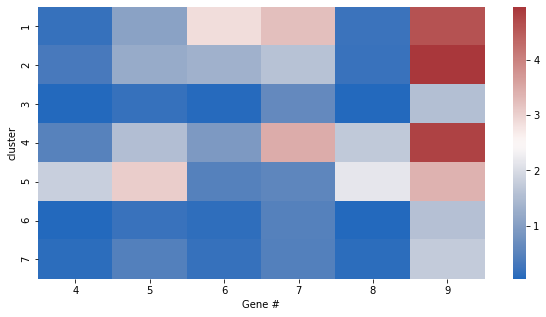

In [396]:
genexpr = pd.DataFrame(inp)
genexpr['cluster'] = labels[0]
#gene expressions for different cell types
fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(genexpr.groupby('cluster')[mgenes_list].mean(),cmap="vlag", ax= ax)
ax.set_xlabel("Gene #")
plt.show()

PCA visualization of how our kmeans functions cluster the data.

In [391]:
[data, labels, names]= load_example_data("CITEseq")
kmeans = KMeans(n_clusters=8, random_state=42).fit(data)
flevel = kmeans.labels_

fl = list(map(lambda x: str(x),flevel))

pca = PCA(n_components = 10)
pca.fit(data)
transformed = pca.transform(data)

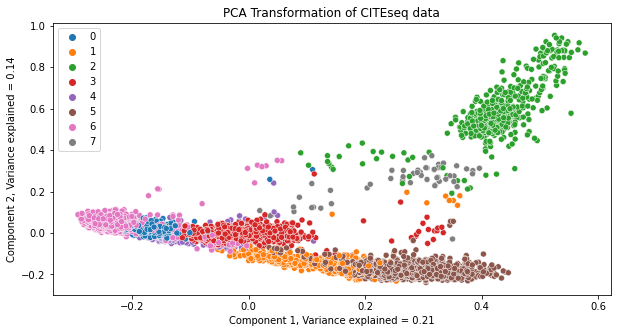

In [392]:
explained = pca.explained_variance_ratio_
h_order = ['0','1','2','3','4','5','6','7']
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue = fl, hue_order = h_order,ax = ax)
ax.set_xlabel("Component 1, Variance explained = {:.2f}".format(explained[0]))
ax.set_ylabel("Component 2, Variance explained = {:.2f}".format(explained[1]))
ax.set_title("PCA Transformation of CITEseq data")
plt.show()

In [393]:
[data, labels, names]= load_example_data("zeisel")
kmeans = KMeans(n_clusters=4, random_state=42).fit(data)
flevel = kmeans.labels_
fl = list(map(lambda x: str(x),flevel))

pca = PCA(n_components = 10)
pca.fit(data)
transformed = pca.transform(data)

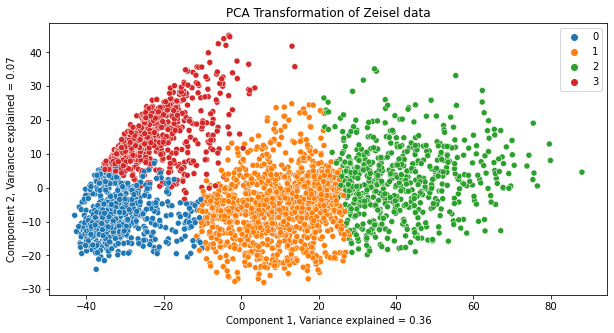

In [394]:
explained = pca.explained_variance_ratio_
h_order = ['0','1','2','3']

fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue = fl,hue_order = h_order,ax = ax)
ax.set_xlabel("Component 1, Variance explained = {:.2f}".format(explained[0]))
ax.set_ylabel("Component 2, Variance explained = {:.2f}".format(explained[1]))
ax.set_title("PCA Transformation of Zeisel data")
plt.show()

### Speed testing

Testing how fast the regressions run as a factor of:

\# of cells in the dataset

\# of marker gene candidates

In [332]:
sizes = [250,500,1000,2000,4000,8000]
mg = 15
[data, labels, names]= load_example_data("CITEseq")
var = normalize(data, norm="l1").var(axis = 0)
ind = np.argpartition(var, -mg)[-mg:]
kmeans = KMeans(n_clusters=8, random_state=42).fit(data)
inp = normalize(data, norm="l1")[:,ind] * 1000
flevel = kmeans.labels_


In [333]:
times = []
for size in sizes:
    total = 0
    for l in np.unique(labels)[:4]:
        start = time()
        obs = np.array(labels == l).astype(int)
        get_bayes_markers(obs[:size],inp[:size,],flevel[:size],mg,True)
        end = time()
        total += (end - start)
    avg = total / 5.0
    print("Average time for sampling {} cells is {}".format(size,avg))
    times.append(avg)

5


logp = -2.1754e+29, ||grad|| = 4.3509e+29: 100%|██████████| 167/167 [00:00<00:00, 1706.62it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 10 divergences: 100%|██████████| 1400/1400 [00:17<00:00, 78.50draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.36  2.09   -4.43     3.30       0.25     0.18     70.69   70.69   
alpha[0] -0.28  2.26   -4.83     3.40       0.25     0.18     80.47   80.47   
alpha[1] -0.31  2.27   -4.26     4.20       0.25     0.18     83.10   83.10   
alpha[2] -0.33  2.40   -4.68     4.06       0.28     0.20     73.60   73.60   
alpha[3] -0.34  2.32   -4.68     3.89       0.27     0.19     75.69   75.69   
alpha[4] -0.35  2.31   -4.60     3.91       0.25     0.18     82.38   82.38   
alpha[5] -0.38  2.40   -5.20     3.98       0.27     0.19     80.69   80.69   
alpha[6] -0.40  2.36   -4.79     3.57       0.26     0.18     83.24   83.24   
alpha[7] -0.35  2.31   -4.58     3.61       0.27     0.19     75.07   75.07   
beta[0]  -0.32  1.53   -3.20     2.72       0.11     0.12    200.06   83.30   
beta[1]  -0.05  1.22   -2.57     2.38       0.07     0.08    279.28  123.86   
beta[2]  -0.16  1.34   -2.88     2.08       0.07    

logp = -2.1754e+29, ||grad|| = 4.3509e+29: 100%|██████████| 167/167 [00:00<00:00, 1644.30it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 11 divergences: 100%|██████████| 1400/1400 [00:17<00:00, 81.59draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.22  2.16   -4.07     3.49       0.30     0.22     50.93   50.93   
alpha[0]  0.20  2.38   -4.36     4.13       0.30     0.22     61.35   61.35   
alpha[1]  0.22  2.50   -4.98     4.11       0.32     0.22     62.64   62.64   
alpha[2]  0.22  2.42   -4.29     4.25       0.31     0.24     59.97   51.58   
alpha[3]  0.22  2.26   -4.16     3.91       0.30     0.21     57.34   57.34   
alpha[4]  0.30  2.37   -3.91     4.40       0.32     0.22     56.03   56.03   
alpha[5]  0.20  2.36   -4.21     4.26       0.31     0.22     58.03   58.03   
alpha[6]  0.25  2.35   -4.18     3.96       0.31     0.22     55.67   55.67   
alpha[7]  0.24  2.31   -4.02     4.57       0.30     0.22     57.92   57.92   
beta[0]  -0.05  1.63   -3.42     3.20       0.11     0.15    216.97   60.18   
beta[1]  -0.20  1.32   -2.72     2.23       0.08     0.07    280.37  162.35   
beta[2]  -0.21  1.55   -3.30     2.21       0.12    

logp = -2.1754e+29, ||grad|| = 4.3509e+29: 100%|██████████| 167/167 [00:00<00:00, 1140.27it/s]
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 8 divergences: 100%|██████████| 1400/1400 [00:15<00:00, 88.44draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.18  1.75   -3.35     3.03       0.19     0.14     87.84   78.61   
alpha[0] -0.16  1.86   -3.75     2.94       0.18     0.13    107.98  107.98   
alpha[1] -0.14  1.89   -3.08     3.96       0.19     0.19    103.74   51.67   
alpha[2] -0.12  1.94   -3.68     3.72       0.19     0.14    102.91  102.91   
alpha[3] -0.14  1.96   -4.12     2.99       0.19     0.16    102.17   76.98   
alpha[4] -0.14  1.92   -3.78     3.03       0.18     0.17    111.10   60.97   
alpha[5] -0.18  1.92   -3.84     3.52       0.18     0.14    110.57   92.01   
alpha[6] -0.18  1.94   -3.56     3.55       0.19     0.16    109.58   75.37   
alpha[7] -0.09  1.90   -3.36     3.45       0.18     0.13    105.85  105.85   
beta[0]  -0.10  1.25   -2.58     1.99       0.09     0.08    217.56  137.07   
beta[1]  -0.21  1.56   -2.88     3.29       0.11     0.11    206.21   94.37   
beta[2]  -0.27  1.34   -2.39     2.35       0.11    

logp = -2.1754e+29, ||grad|| = 4.3509e+29: 100%|██████████| 167/167 [00:00<00:00, 1888.58it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 5 divergences: 100%|██████████| 1400/1400 [00:15<00:00, 88.10draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.11  2.08   -3.61     3.77       0.28     0.20     54.38   54.38   
alpha[0]  0.19  2.36   -4.27     4.16       0.30     0.21     60.87   60.87   
alpha[1]  0.18  2.30   -4.04     4.25       0.30     0.21     59.90   59.90   
alpha[2]  0.14  2.41   -3.92     4.36       0.31     0.22     61.05   61.05   
alpha[3]  0.20  2.38   -4.51     3.92       0.31     0.22     57.44   57.24   
alpha[4]  0.14  2.21   -3.68     4.10       0.28     0.20     60.59   60.59   
alpha[5]  0.07  2.37   -3.87     4.93       0.28     0.20     70.38   70.38   
alpha[6]  0.14  2.33   -4.25     4.17       0.30     0.21     60.77   60.77   
alpha[7]  0.08  2.28   -3.66     4.48       0.28     0.20     64.25   64.25   
beta[0]  -0.14  1.65   -3.49     3.59       0.14     0.14    140.98   66.09   
beta[1]  -0.11  1.33   -2.78     2.31       0.06     0.10    562.95   82.35   
beta[2]  -0.30  1.37   -2.68     2.43       0.10    

logp = 83.627, ||grad|| = 2.6156e+08: 100%|██████████| 179/179 [00:00<00:00, 1628.41it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 3 divergences: 100%|██████████| 1400/1400 [00:18<00:00, 77.11draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.65  1.80   -3.88     2.53       0.31     0.22     34.01   34.01   
alpha[0] -0.61  1.94   -3.99     2.83       0.30     0.21     42.14   42.14   
alpha[1] -0.71  2.04   -4.34     2.91       0.34     0.24     35.96   35.96   
alpha[2] -0.62  2.03   -4.35     2.87       0.30     0.21     46.19   46.19   
alpha[3] -0.68  2.13   -4.48     2.82       0.34     0.25     38.28   38.28   
alpha[4] -0.62  1.95   -3.77     3.21       0.31     0.22     38.42   38.42   
alpha[5] -0.69  1.98   -4.37     3.01       0.31     0.22     41.14   41.14   
alpha[6] -0.66  2.01   -4.17     3.05       0.32     0.23     38.16   38.16   
alpha[7] -0.70  2.03   -3.91     3.24       0.32     0.23     40.48   40.48   
beta[0]  -0.34  1.26   -2.84     1.99       0.07     0.07    320.84  186.20   
beta[1]  -0.53  1.15   -3.37     1.16       0.06     0.06    311.56  171.26   
beta[2]  -0.79  1.38   -3.88     1.52       0.12    

logp = 83.627, ||grad|| = 2.6156e+08: 100%|██████████| 179/179 [00:00<00:00, 1457.73it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 6 divergences: 100%|██████████| 1400/1400 [00:19<00:00, 71.13draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7078041384143586, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.23  1.88   -4.38     2.77       0.21     0.15     82.90   82.90   
alpha[0] -0.30  2.12   -4.04     3.97       0.22     0.15     96.89   96.89   
alpha[1] -0.28  2.09   -3.99     3.77       0.21     0.15     99.66   99.66   
alpha[2] -0.25  2.15   -4.36     3.60       0.23     0.16     89.89   89.89   
alpha[3] -0.16  2.09   -4.10     3.57       0.22     0.16     88.28   88.28   
alpha[4] -0.23  2.05   -4.29     3.36       0.21     0.15     94.85   94.85   
alpha[5] -0.24  2.14   -4.38     3.97       0.22     0.16     92.85   92.85   
alpha[6] -0.19  2.13   -4.02     3.93       0.21     0.15     99.58   99.58   
alpha[7] -0.24  2.21   -4.37     4.05       0.23     0.16     96.03   96.03   
beta[0]  -0.30  1.29   -3.19     1.78       0.08     0.07    269.54  158.57   
beta[1]  -0.63  1.42   -3.51     1.57       0.15     0.14     90.45   49.97   
beta[2]  -0.94  1.67   -4.21     1.86       0.14    

logp = 83.627, ||grad|| = 2.6156e+08: 100%|██████████| 179/179 [00:00<00:00, 1714.29it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 7 divergences: 100%|██████████| 1400/1400 [00:20<00:00, 69.88draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7193336181453015, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.53  1.91   -4.43     2.80       0.38     0.27     25.72   25.72   
alpha[0] -0.52  2.29   -4.32     3.94       0.28     0.20     65.76   65.76   
alpha[1] -0.68  2.29   -4.55     4.12       0.53     0.38     18.91   18.91   
alpha[2] -0.58  2.13   -4.66     3.25       0.34     0.25     38.20   38.20   
alpha[3] -0.60  2.23   -4.55     3.59       0.42     0.30     27.66   27.66   
alpha[4] -0.58  2.17   -4.64     3.51       0.46     0.33     22.04   22.04   
alpha[5] -0.39  2.26   -4.48     4.17       0.32     0.23     50.37   50.37   
alpha[6] -0.44  2.15   -4.99     3.06       0.30     0.21     51.35   51.35   
alpha[7] -0.61  2.29   -4.57     4.03       0.36     0.26     40.72   40.72   
beta[0]  -0.24  1.23   -2.75     1.91       0.11     0.11    129.20   65.35   
beta[1]  -0.47  1.24   -3.23     1.58       0.12     0.08    112.09  112.09   
beta[2]  -0.70  1.33   -3.36     1.31       0.15    

logp = 41.182, ||grad|| = 157.61: 100%|██████████| 217/217 [00:00<00:00, 1740.83it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 2 divergences: 100%|██████████| 1400/1400 [00:22<00:00, 61.39draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.13  1.57   -2.64     3.42       0.19     0.13     68.58   68.58   
alpha[0]  0.07  1.86   -3.50     3.50       0.30     0.21     38.93   38.93   
alpha[1]  0.06  1.85   -3.10     3.65       0.17     0.12    124.92  124.92   
alpha[2]  0.13  1.96   -3.34     3.71       0.18     0.13    120.32  120.32   
alpha[3]  0.14  1.85   -3.68     3.12       0.18     0.13    105.59  105.59   
alpha[4]  0.33  1.90   -3.41     3.67       0.21     0.15     79.35   79.35   
alpha[5]  0.12  2.01   -3.24     4.67       0.16     0.13    150.05  114.19   
alpha[6]  0.10  1.89   -3.34     3.81       0.25     0.18     56.88   56.88   
alpha[7]  0.17  1.91   -3.42     3.82       0.21     0.15     84.22   84.22   
beta[0]   0.16  1.20   -2.29     2.24       0.08     0.08    209.71  117.85   
beta[1]   0.50  1.09   -1.46     2.51       0.07     0.05    274.05  256.12   
beta[2]   0.17  1.06   -1.96     2.15       0.07    

logp = 7.7626, ||grad|| = 2.9324e+08: 100%|██████████| 351/351 [00:00<00:00, 1684.00it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 4 divergences: 100%|██████████| 1400/1400 [00:09<00:00, 151.81draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.21  1.16   -2.12     2.27       0.21     0.15     31.45   31.45   
alpha[0]  1.76  1.70   -1.47     4.71       0.24     0.17     52.25   52.25   
alpha[1] -0.08  1.62   -3.41     2.54       0.30     0.22     28.50   28.50   
alpha[2] -0.26  1.84   -3.85     3.42       0.19     0.13     94.45   94.45   
alpha[3] -1.17  1.61   -4.26     1.66       0.17     0.12     85.95   85.95   
alpha[4] -0.92  1.05   -2.88     0.98       0.13     0.09     70.47   70.47   
alpha[5] -0.26  1.84   -3.44     3.23       0.18     0.12    109.54  109.54   
alpha[6] -0.76  1.07   -2.37     1.49       0.14     0.10     61.71   61.71   
alpha[7] -0.27  1.74   -3.60     2.87       0.21     0.15     67.92   67.92   
beta[0]  -0.63  0.33   -1.26    -0.07       0.02     0.02    199.29  164.40   
beta[1]  -0.18  0.21   -0.56     0.24       0.01     0.01    209.71  209.71   
beta[2]  -0.03  0.25   -0.50     0.40       0.02    

logp = -83.588, ||grad|| = 1.6415e+09: 100%|██████████| 420/420 [00:00<00:00, 1531.40it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 1 divergences: 100%|██████████| 1400/1400 [00:13<00:00, 104.44draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.07  1.06   -5.92    -2.11       0.10     0.07    115.47  111.97   
alpha[0] -4.23  1.29   -6.73    -1.95       0.10     0.07    174.01  165.82   
alpha[1] -3.31  1.19   -5.51    -1.27       0.11     0.08    113.80  104.82   
alpha[2] -4.17  1.45   -6.84    -1.42       0.10     0.07    201.99  199.14   
alpha[3] -4.23  1.43   -7.12    -1.72       0.10     0.07    209.40  196.81   
alpha[4] -4.92  1.10   -6.92    -3.06       0.08     0.06    181.39  181.39   
alpha[5] -4.10  1.54   -6.80    -1.25       0.11     0.08    180.11  180.08   
alpha[6] -4.73  1.23   -7.31    -2.60       0.09     0.07    179.86  176.73   
alpha[7] -4.03  1.60   -7.12    -1.21       0.14     0.10    129.24  129.24   
beta[0]  -0.32  0.30   -0.93     0.17       0.01     0.01    437.64  310.44   
beta[1]  -0.38  0.26   -0.89     0.06       0.01     0.02    339.34  106.64   
beta[2]   0.05  0.21   -0.32     0.50       0.01    

logp = -50.026, ||grad|| = 12,104: 100%|██████████| 198/198 [00:00<00:00, 1370.40it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:11<00:00, 125.22draws/s]
The acceptance probability does not match the target. It is 0.891483596517299, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -5.80  1.47   -8.82    -3.32       0.13     0.09    121.54  121.54   
alpha[0] -6.34  2.27  -10.16    -2.25       0.16     0.11    206.57  206.57   
alpha[1] -4.07  2.02   -7.98    -0.58       0.17     0.12    141.68  141.68   
alpha[2] -5.95  2.71  -10.87    -0.39       0.22     0.16    150.64  150.64   
alpha[3] -6.97  2.03  -10.25    -2.91       0.14     0.10    208.59  208.40   
alpha[4] -8.48  1.93  -12.05    -4.69       0.15     0.10    172.52  172.52   
alpha[5] -6.02  2.38  -10.81    -2.15       0.17     0.12    198.39  198.39   
alpha[6] -7.89  1.80  -11.55    -4.84       0.13     0.09    187.55  187.55   
alpha[7] -5.99  2.54  -10.62    -1.16       0.18     0.13    198.25  198.25   
beta[0]  -0.11  0.37   -0.77     0.63       0.03     0.02    210.29  210.29   
beta[1]   0.04  0.30   -0.53     0.59       0.02     0.01    235.56  235.56   
beta[2]   1.54  0.38    0.90     2.31       0.03    

logp = -98.766, ||grad|| = 1.9042: 100%|██████████| 154/154 [00:00<00:00, 1249.31it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:09<00:00, 151.68draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -3.53  1.52   -6.61    -0.92       0.16     0.13     90.46   71.63   
alpha[0] -5.18  2.19   -9.17    -1.37       0.21     0.16    105.04  100.14   
alpha[1] -6.66  2.41  -10.97    -2.30       0.23     0.17    106.58  106.58   
alpha[2] -3.57  3.12   -9.96     1.79       0.22     0.19    197.44  135.63   
alpha[3] -4.72  2.52   -9.30    -0.58       0.23     0.17    120.75  110.58   
alpha[4]  1.05  1.10   -0.95     3.17       0.11     0.08     97.05   97.05   
alpha[5] -3.78  3.05   -9.20     1.76       0.20     0.15    239.17  204.56   
alpha[6] -6.95  1.76  -10.11    -3.70       0.18     0.13     98.52   98.09   
alpha[7] -3.51  2.94  -10.06     1.48       0.23     0.18    166.90  139.93   
beta[0]  -0.57  0.25   -1.10    -0.11       0.01     0.01    312.82  275.15   
beta[1]  -0.31  0.23   -0.80     0.05       0.01     0.01    268.29  214.00   
beta[2]   0.93  0.34    0.34     1.57       0.04    

logp = -171.82, ||grad|| = 1.9404: 100%|██████████| 145/145 [00:00<00:00, 1308.63it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:14<00:00, 97.48draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.41  1.08   -2.45     1.45       0.10     0.07    118.52  116.21   
alpha[0]  4.49  1.24    1.92     6.57       0.10     0.07    161.10  161.10   
alpha[1] -0.22  1.34   -3.15     1.84       0.13     0.09    112.76  112.76   
alpha[2] -0.72  2.36   -5.51     3.25       0.14     0.11    266.52  218.07   
alpha[3] -1.95  1.43   -4.57     0.69       0.13     0.10    118.00  113.49   
alpha[4] -1.23  0.72   -2.54     0.15       0.07     0.05    102.58   93.80   
alpha[5] -0.93  2.22   -4.86     3.59       0.15     0.11    223.85  206.46   
alpha[6] -2.06  0.65   -3.27    -0.95       0.07     0.05     97.75   82.20   
alpha[7] -0.67  2.21   -4.67     3.40       0.14     0.12    232.19  167.01   
beta[0]  -0.56  0.21   -0.91    -0.16       0.01     0.01    309.62  292.10   
beta[1]  -0.18  0.14   -0.45     0.04       0.01     0.01    187.88  187.88   
beta[2]  -0.06  0.15   -0.36     0.20       0.01    

logp = -6.8205e+34, ||grad|| = 1.3641e+35: 100%|██████████| 389/389 [00:00<00:00, 1204.03it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:24<00:00, 57.33draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.21  0.69   -5.75    -3.15       0.06     0.04    123.90  123.90   
alpha[0] -4.50  0.92   -6.13    -2.67       0.06     0.04    269.20  255.74   
alpha[1] -3.42  0.61   -4.69    -2.33       0.04     0.03    199.06  199.06   
alpha[2] -4.19  1.42   -7.01    -1.59       0.11     0.08    158.42  158.42   
alpha[3] -4.58  1.04   -6.40    -2.82       0.07     0.05    240.55  211.74   
alpha[4] -5.02  0.82   -6.70    -3.66       0.05     0.04    251.98  233.66   
alpha[5] -3.91  0.83   -5.36    -2.32       0.07     0.05    153.85  153.85   
alpha[6] -4.91  0.67   -6.38    -3.82       0.04     0.03    339.98  320.87   
alpha[7] -4.27  1.31   -6.91    -1.51       0.09     0.07    203.74  203.74   
beta[0]  -0.23  0.15   -0.49     0.03       0.01     0.01    416.47  292.83   
beta[1]  -0.22  0.13   -0.45     0.04       0.01     0.00    523.05  523.05   
beta[2]   0.00  0.12   -0.22     0.25       0.01    

logp = -160.59, ||grad|| = 0.067663: 100%|██████████| 378/378 [00:00<00:00, 680.14it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:22<00:00, 62.06draws/s]
The acceptance probability does not match the target. It is 0.8823001235329895, but should be close to 0.8. Try to increase the number of tuning steps.


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -8.20  1.45  -10.58    -5.33       0.09     0.07    246.53  242.04   
alpha[0] -10.74  2.04  -14.84    -7.34       0.12     0.08    315.00  302.68   
alpha[1]  -5.61  1.10   -7.79    -3.76       0.07     0.05    248.81  248.81   
alpha[2]  -8.39  3.18  -14.13    -2.21       0.17     0.12    337.52  337.52   
alpha[3] -13.24  2.06  -16.46    -9.29       0.14     0.10    215.19  215.19   
alpha[4] -12.19  1.75  -16.11    -9.47       0.13     0.09    185.47  183.58   
alpha[5]  -9.03  2.73  -14.05    -3.66       0.17     0.13    272.25  237.83   
alpha[6] -12.04  1.74  -15.43    -9.16       0.13     0.10    171.15  167.33   
alpha[7]  -9.05  2.92  -14.83    -3.87       0.18     0.13    274.22  261.60   
beta[0]    0.33  0.23   -0.02     0.82       0.01     0.01    392.98  366.71   
beta[1]    0.25  0.20   -0.19     0.58       0.01     0.01    261.27  228.35   
beta[2]    1.29  0.16    0.93     1.56  

logp = -136.44, ||grad|| = 0.011192: 100%|██████████| 198/198 [00:00<00:00, 872.09it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:23<00:00, 60.06draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -3.25  1.38   -5.76    -0.81       0.13     0.09    118.24  118.24   
alpha[0] -5.90  2.09   -9.92    -2.39       0.19     0.13    123.48  123.48   
alpha[1] -4.77  2.59   -9.29     0.21       0.17     0.14    227.97  184.57   
alpha[2] -3.46  2.92   -9.79     1.04       0.21     0.15    201.08  201.08   
alpha[3] -5.65  2.40  -10.23    -1.53       0.22     0.16    122.43  110.39   
alpha[4]  1.95  0.78    0.51     3.36       0.07     0.05    119.19  111.81   
alpha[5] -3.51  2.86   -9.32     1.17       0.23     0.17    151.25  150.27   
alpha[6] -7.36  1.51   -9.78    -4.46       0.12     0.08    169.21  167.13   
alpha[7] -3.14  3.09   -8.73     2.25       0.21     0.16    211.75  195.00   
beta[0]  -1.27  0.21   -1.67    -0.87       0.01     0.01    231.28  222.96   
beta[1]  -0.11  0.14   -0.40     0.15       0.01     0.01    390.33  229.99   
beta[2]   0.33  0.20   -0.04     0.69       0.02    

logp = -211.19, ||grad|| = 0.42563: 100%|██████████| 254/254 [00:00<00:00, 844.33it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:20<00:00, 67.47draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.38  1.06   -2.24     1.64       0.07     0.05    216.37  216.37   
alpha[0]  5.58  0.88    4.04     7.29       0.06     0.05    188.66  187.36   
alpha[1]  0.25  1.39   -2.32     2.78       0.09     0.07    219.44  219.44   
alpha[2] -0.39  2.53   -5.12     3.97       0.12     0.12    446.05  209.52   
alpha[3] -2.14  1.18   -4.19    -0.05       0.07     0.05    272.50  257.15   
alpha[4] -0.93  0.61   -1.94     0.22       0.04     0.03    192.58  192.58   
alpha[5] -1.64  2.37   -5.97     2.39       0.16     0.12    226.95  209.88   
alpha[6] -3.32  0.54   -4.27    -2.22       0.04     0.03    193.68  193.68   
alpha[7] -0.80  2.55   -5.63     3.40       0.14     0.11    346.10  289.49   
beta[0]  -0.61  0.19   -0.95    -0.29       0.01     0.01    461.08  449.75   
beta[1]  -0.15  0.13   -0.38     0.11       0.01     0.01    379.80  235.14   
beta[2]  -0.18  0.13   -0.42     0.05       0.01    

logp = -515.31, ||grad|| = 2.3319e+09: 100%|██████████| 430/430 [00:00<00:00, 969.42it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:32<00:00, 42.49draws/s]
The acceptance probability does not match the target. It is 0.8861837742580175, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -5.63  0.53   -6.67    -4.67       0.04     0.03    162.93  161.64   
alpha[0] -5.84  0.83   -7.55    -4.37       0.05     0.04    247.25  227.99   
alpha[1] -5.02  0.47   -5.82    -4.11       0.03     0.02    219.53  219.53   
alpha[2] -5.71  0.89   -7.31    -4.10       0.06     0.04    204.35  194.92   
alpha[3] -5.99  0.77   -7.39    -4.67       0.05     0.03    268.94  268.94   
alpha[4] -5.94  0.72   -7.21    -4.48       0.04     0.03    330.12  315.27   
alpha[5] -5.84  0.62   -7.02    -4.85       0.04     0.03    211.03  210.90   
alpha[6] -5.81  0.50   -6.73    -4.93       0.03     0.02    263.32  263.32   
alpha[7] -5.69  0.92   -7.51    -3.94       0.06     0.04    224.58  222.07   
beta[0]  -0.04  0.11   -0.25     0.15       0.01     0.01    444.70  187.31   
beta[1]  -0.04  0.10   -0.22     0.14       0.00     0.00    465.73  249.29   
beta[2]  -0.07  0.09   -0.27     0.07       0.01    

logp = -218.42, ||grad|| = 2.0875: 100%|██████████| 443/443 [00:00<00:00, 984.86it/s]  
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:41<00:00, 33.96draws/s]


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -7.31  1.38   -9.73    -4.55       0.08     0.06    278.80  278.80   
alpha[0] -11.78  1.90  -15.23    -8.61       0.10     0.07    354.83  338.89   
alpha[1]  -4.55  0.90   -6.19    -2.97       0.05     0.04    283.48  274.43   
alpha[2]  -7.61  3.59  -13.78    -0.15       0.19     0.13    373.97  373.97   
alpha[3] -15.05  2.23  -19.45   -11.14       0.13     0.09    300.36  291.81   
alpha[4] -12.29  1.76  -15.13    -9.05       0.11     0.08    270.39  246.82   
alpha[5]  -5.47  1.75   -8.70    -2.29       0.10     0.07    306.12  278.62   
alpha[6] -11.96  1.12  -14.31   -10.20       0.06     0.04    366.36  349.19   
alpha[7]  -8.56  3.32  -14.64    -2.16       0.17     0.13    371.60  336.88   
beta[0]    0.19  0.19   -0.19     0.51       0.01     0.01    346.81  319.90   
beta[1]    0.32  0.15    0.01     0.57       0.01     0.01    320.70  273.49   
beta[2]    1.26  0.14    0.99     1.48  

logp = -145.57, ||grad|| = 0.92833: 100%|██████████| 237/237 [00:00<00:00, 996.84it/s]  
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:22<00:00, 61.57draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -3.68  1.36   -6.58    -1.36       0.15     0.11     77.91   77.91   
alpha[0] -6.98  1.91  -10.18    -3.46       0.17     0.12    130.59  130.59   
alpha[1] -5.15  2.71  -10.76    -0.74       0.29     0.20     87.71   87.71   
alpha[2] -4.20  3.08  -10.39     0.63       0.25     0.18    149.74  141.07   
alpha[3] -6.49  2.77  -11.21    -1.94       0.29     0.20     92.69   92.69   
alpha[4]  2.05  0.76    0.67     3.47       0.14     0.10     30.03   30.03   
alpha[5] -4.40  3.02   -9.73     1.58       0.25     0.18    143.59  134.80   
alpha[6] -8.82  1.65  -11.61    -5.96       0.15     0.11    125.56  117.96   
alpha[7] -3.56  3.31   -9.58     3.07       0.23     0.17    204.02  199.56   
beta[0]  -1.27  0.18   -1.62    -0.97       0.01     0.01    302.97  292.95   
beta[1]  -0.06  0.14   -0.33     0.18       0.01     0.01    432.49  126.62   
beta[2]   0.23  0.17   -0.09     0.53       0.02    

logp = -252.12, ||grad|| = 0.37033: 100%|██████████| 295/295 [00:00<00:00, 538.99it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:39<00:00, 35.21draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.38  1.20   -2.70     1.69       0.08     0.05    241.32  241.32   
alpha[0]  6.59  0.82    5.15     8.17       0.06     0.04    182.73  182.73   
alpha[1] -0.43  1.36   -3.08     2.02       0.10     0.07    197.64  174.73   
alpha[2] -0.57  2.86   -5.59     5.05       0.15     0.14    384.94  197.15   
alpha[3] -3.38  1.20   -5.97    -1.33       0.09     0.06    197.53  181.65   
alpha[4] -0.80  0.58   -2.00     0.25       0.05     0.03    159.88  152.60   
alpha[5] -0.73  2.11   -4.51     3.46       0.14     0.11    225.04  192.89   
alpha[6] -3.85  0.48   -4.75    -2.94       0.04     0.03    167.05  167.05   
alpha[7] -1.04  2.73   -5.56     4.35       0.16     0.13    287.58  218.85   
beta[0]  -0.43  0.17   -0.78    -0.14       0.01     0.01    422.51  384.16   
beta[1]  -0.17  0.11   -0.37     0.03       0.01     0.00    289.43  289.43   
beta[2]  -0.24  0.11   -0.46    -0.04       0.01    

logp = -761.01, ||grad|| = 1.8967: 100%|██████████| 347/347 [00:00<00:00, 643.79it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:54<00:00, 25.78draws/s]
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -6.52  0.64   -7.80    -5.46       0.04     0.03    292.72  292.72   
alpha[0] -7.05  0.96   -8.88    -5.33       0.05     0.03    452.94  439.44   
alpha[1] -5.63  0.43   -6.48    -4.90       0.03     0.02    281.72  281.72   
alpha[2] -6.78  1.26   -9.18    -4.29       0.07     0.05    333.08  325.57   
alpha[3] -8.00  1.06  -10.00    -6.06       0.09     0.06    150.28  147.11   
alpha[4] -6.66  0.78   -8.17    -5.32       0.04     0.03    375.85  372.99   
alpha[5] -6.77  0.59   -7.88    -5.78       0.04     0.03    275.95  275.95   
alpha[6] -6.37  0.41   -7.06    -5.54       0.02     0.02    339.80  338.73   
alpha[7] -6.74  1.35   -9.38    -4.32       0.07     0.05    405.69  396.53   
beta[0]  -0.02  0.08   -0.16     0.13       0.00     0.00    355.95  206.46   
beta[1]   0.15  0.08    0.01     0.30       0.00     0.00    375.43  334.50   
beta[2]  -0.08  0.07   -0.22     0.05       0.00    

logp = -266.81, ||grad|| = 2.3526: 100%|██████████| 458/458 [00:00<00:00, 661.45it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:50<00:00, 27.53draws/s]


           mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      -7.00  1.39   -9.40    -4.42       0.10     0.07    196.05  184.40   
alpha[0] -12.66  1.92  -16.01    -9.32       0.14     0.10    200.78  189.52   
alpha[1]  -2.94  0.70   -4.29    -1.76       0.05     0.04    179.27  178.62   
alpha[2]  -7.71  3.82  -14.53    -0.57       0.22     0.17    303.05  245.76   
alpha[3] -16.26  2.02  -20.52   -12.95       0.14     0.10    203.63  199.63   
alpha[4] -11.39  2.09  -15.24    -8.08       0.12     0.09    281.44  265.48   
alpha[5]  -5.17  1.22   -7.14    -2.71       0.09     0.06    200.81  200.81   
alpha[6] -12.34  1.10  -14.32   -10.37       0.07     0.05    232.72  232.72   
alpha[7]  -8.25  3.43  -14.91    -2.18       0.22     0.16    240.17  239.51   
beta[0]    0.05  0.14   -0.18     0.33       0.01     0.01    330.61  259.01   
beta[1]    0.18  0.13   -0.04     0.46       0.01     0.01    222.93  148.35   
beta[2]    1.08  0.13    0.85     1.34  

logp = -150.2, ||grad|| = 2.426: 100%|██████████| 254/254 [00:00<00:00, 581.68it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [00:38<00:00, 35.95draws/s]


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -4.11  1.35   -6.77    -1.83       0.11     0.08    138.29  138.29   
alpha[0] -8.06  1.76  -11.22    -4.64       0.12     0.08    232.75  231.30   
alpha[1] -5.31  2.88  -10.93    -0.30       0.22     0.15    177.57  177.57   
alpha[2] -4.67  3.23   -9.94     1.65       0.19     0.14    280.23  261.44   
alpha[3] -7.69  2.34  -12.19    -3.79       0.20     0.14    136.12  136.12   
alpha[4]  2.20  0.76    0.77     3.45       0.07     0.05    121.51  121.51   
alpha[5] -5.12  3.18  -11.17     0.39       0.20     0.14    242.52  241.86   
alpha[6] -9.83  1.80  -12.97    -6.66       0.14     0.10    161.86  154.20   
alpha[7] -4.11  3.19   -9.39     2.14       0.19     0.14    275.16  266.42   
beta[0]  -1.24  0.16   -1.53    -0.93       0.01     0.01    219.75  217.35   
beta[1]  -0.09  0.14   -0.35     0.16       0.01     0.01    284.72  284.72   
beta[2]   0.23  0.16   -0.06     0.53       0.01    

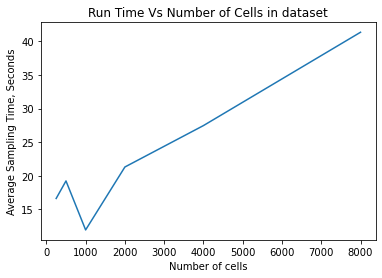

In [335]:
sns.reset_orig()
plt.plot(sizes,times)
plt.xlabel("Number of cells")
plt.ylabel("Average Sampling Time, Seconds")
plt.title("Run Time Vs Number of Cells in dataset")
plt.show()

In [343]:
mgenes= [10,20,30,50]
var = normalize(data, norm="l1").var(axis = 0)
# kmeans = KMeans(n_clusters=8, random_state=42).fit(data)
flevel = kmeans.labels_
marker_times = []
for mg in mgenes:
    total = 0
    ind = np.argpartition(var, -mg)[-mg:]
    inp = normalize(data, norm="l1")[:,ind] * 1000
    for l in np.unique(labels)[:4]:
        start = time()
        obs = np.array(labels == l).astype(int)
        get_bayes_markers(obs[:500],inp[:500],flevel[:500],mg,True)
        end = time()
        total += (end - start)
    avg = total / 5.0
    print("Average time for sampling {} markers is {}".format(mg,avg))
    marker_times.append(avg)


logp = 113.15, ||grad|| = 1.7439e+08: 100%|██████████| 200/200 [00:00<00:00, 1173.97it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 22 divergences: 100%|██████████| 1400/1400 [00:16<00:00, 83.58draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6052533877196193, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7159437779166896, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for som

          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.87  1.95   -4.24     2.65       0.45     0.33     18.43   18.43   
alpha[0] -0.86  2.12   -4.31     3.28       0.40     0.28     28.67   28.67   
alpha[1] -0.92  2.11   -4.57     2.96       0.40     0.29     27.82   27.82   
alpha[2] -0.91  2.13   -4.33     3.22       0.39     0.28     29.96   29.96   
alpha[3] -0.95  2.11   -4.62     3.13       0.49     0.35     18.23   18.23   
alpha[4] -0.91  2.05   -4.33     3.16       0.44     0.31     21.94   21.94   
alpha[5] -0.94  2.13   -4.58     3.21       0.46     0.33     21.47   21.47   
alpha[6] -0.85  2.21   -4.64     3.43       0.46     0.33     23.39   23.39   
alpha[7] -0.80  2.16   -4.17     3.70       0.51     0.36     18.08   18.08   
beta[0]  -0.67  1.02   -2.55     1.02       0.11     0.08     84.59   84.59   
beta[1]  -0.59  1.46   -3.76     1.65       0.21     0.15     49.28   49.28   
beta[2]  -0.51  1.06   -2.42     1.33       0.09    

logp = 113.15, ||grad|| = 1.7439e+08: 100%|██████████| 200/200 [00:00<00:00, 1601.69it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 27 divergences: 100%|██████████| 1400/1400 [00:15<00:00, 90.24draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6396076220720337, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.57  1.71   -3.68     2.93       0.21     0.15     66.07   66.07   
alpha[0] -0.63  1.99   -4.51     3.14       0.24     0.17     68.43   68.43   
alpha[1] -0.64  2.01   -4.49     3.23       0.25     0.17     66.87   66.87   
alpha[2] -0.60  1.87   -4.06     2.68       0.21     0.15     79.47   79.47   
alpha[3] -0.56  1.85   -4.21     2.82       0.22     0.15     74.10   74.10   
alpha[4] -0.69  1.99   -4.55     2.69       0.22     0.17     80.14   70.12   
alpha[5] -0.57  1.97   -4.41     3.13       0.22     0.15     81.50   81.50   
alpha[6] -0.59  1.89   -4.17     3.03       0.21     0.15     83.41   83.41   
alpha[7] -0.61  1.96   -4.07     3.31       0.23     0.17     69.80   67.98   
beta[0]  -0.42  1.01   -2.25     1.16       0.17     0.12     33.84   33.84   
beta[1]  -0.52  1.20   -2.96     1.49       0.09     0.08    166.15  122.17   
beta[2]  -0.69  1.27   -2.78     1.61       0.25    

logp = 113.15, ||grad|| = 1.7439e+08: 100%|██████████| 200/200 [00:00<00:00, 1820.23it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 6 divergences: 100%|██████████| 1400/1400 [00:21<00:00, 65.52draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.48  2.02   -4.33     3.10       0.26     0.20     58.80   52.96   
alpha[0] -0.58  2.34   -4.73     3.66       0.28     0.21     71.62   62.80   
alpha[1] -0.51  2.24   -4.83     3.47       0.28     0.20     62.50   62.50   
alpha[2] -0.48  2.38   -4.65     3.80       0.32     0.23     56.22   56.22   
alpha[3] -0.52  2.49   -5.01     4.45       0.30     0.22     67.30   67.30   
alpha[4] -0.58  2.38   -4.80     4.14       0.28     0.28     72.67   37.53   
alpha[5] -0.44  2.45   -4.79     4.35       0.33     0.23     56.19   56.19   
alpha[6] -0.51  2.34   -4.87     3.56       0.28     0.22     72.61   55.49   
alpha[7] -0.52  2.30   -5.14     3.32       0.24     0.17     89.35   89.35   
beta[0]  -0.52  0.92   -2.67     0.89       0.06     0.05    229.65  188.24   
beta[1]  -0.49  1.21   -3.18     1.43       0.09     0.11    189.02   62.17   
beta[2]  -0.63  1.27   -3.27     1.44       0.09    

logp = -1.2406e+35, ||grad|| = 2.4811e+35: 100%|██████████| 190/190 [00:00<00:00, 1730.34it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 68 divergences: 100%|██████████| 1400/1400 [00:17<00:00, 78.49draws/s]
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48244413100303746, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      1.08  1.37   -1.53     3.48       0.16     0.11     71.39   71.39   
alpha[0]  1.05  1.49   -1.80     3.62       0.17     0.12     78.90   78.90   
alpha[1]  1.07  1.48   -1.55     3.86       0.17     0.12     72.49   72.49   
alpha[2]  1.05  1.52   -1.61     3.90       0.17     0.12     82.10   82.10   
alpha[3]  1.02  1.53   -2.29     3.40       0.16     0.11     90.01   90.01   
alpha[4]  1.22  1.47   -1.69     4.03       0.16     0.11     84.16   84.16   
alpha[5]  1.09  1.49   -1.66     3.84       0.17     0.12     77.05   77.05   
alpha[6]  1.11  1.52   -1.20     4.65       0.17     0.12     76.95   76.95   
alpha[7]  1.10  1.54   -1.63     4.15       0.16     0.12     89.13   89.13   
beta[0]  -0.52  0.61   -1.43     0.46       0.14     0.10     19.71   19.71   
beta[1]  -1.04  1.13   -3.29     0.87       0.14     0.10     70.64   70.64   
beta[2]   0.36  0.88   -1.19     1.59       0.34    

logp = -2,388.1, ||grad|| = 1.1086e+10: 100%|██████████| 180/180 [00:00<00:00, 1489.22it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 7 divergences: 100%|██████████| 1400/1400 [00:24<00:00, 57.10draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.53  2.01   -4.37     3.15       0.21     0.15     88.35   88.35   
alpha[0] -0.47  2.20   -4.28     4.03       0.23     0.16     92.40   92.40   
alpha[1] -0.62  2.18   -5.22     2.95       0.22     0.16     97.03   97.03   
alpha[2] -0.52  2.30   -5.02     3.72       0.23     0.16    103.55  103.55   
alpha[3] -0.55  2.20   -4.63     3.52       0.22     0.15    105.06  105.06   
alpha[4] -0.49  2.21   -5.31     3.09       0.23     0.16     94.61   94.61   
alpha[5] -0.51  2.25   -5.19     3.19       0.24     0.17     88.82   88.82   
alpha[6] -0.58  2.16   -5.40     3.05       0.23     0.16     92.04   92.04   
alpha[7] -0.54  2.23   -4.96     3.17       0.23     0.16     98.02   98.02   
beta[0]  -0.11  1.26   -2.54     2.26       0.09     0.07    214.45  174.99   
beta[1]  -0.52  1.36   -3.43     1.74       0.08     0.09    294.34  113.02   
beta[2]  -0.35  1.46   -3.33     2.34       0.09    

logp = -2,388.1, ||grad|| = 1.1086e+10: 100%|██████████| 180/180 [00:00<00:00, 1622.37it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 8 divergences: 100%|██████████| 1400/1400 [00:21<00:00, 66.26draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.10  2.39   -4.60     3.71       0.32     0.23     54.36   54.36   
alpha[0] -0.04  2.55   -4.31     4.67       0.32     0.23     63.79   63.79   
alpha[1] -0.13  2.52   -4.62     4.24       0.29     0.20     76.65   76.65   
alpha[2] -0.10  2.58   -5.18     4.46       0.30     0.21     74.06   74.06   
alpha[3] -0.10  2.58   -5.13     4.07       0.29     0.21     76.38   76.38   
alpha[4] -0.13  2.58   -4.59     4.68       0.35     0.25     55.62   55.62   
alpha[5] -0.13  2.55   -4.64     4.20       0.37     0.27     46.66   46.66   
alpha[6] -0.16  2.49   -4.83     4.43       0.30     0.21     70.08   70.08   
alpha[7] -0.09  2.56   -5.05     4.16       0.30     0.22     71.21   71.21   
beta[0]  -0.19  1.80   -3.01     4.38       0.11     0.16    258.43   61.75   
beta[1]  -0.57  1.52   -3.58     2.25       0.12     0.12    161.97   78.93   
beta[2]  -0.26  1.38   -2.72     2.44       0.12    

logp = -2,388.1, ||grad|| = 1.1086e+10: 100%|██████████| 180/180 [00:00<00:00, 1333.48it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 5 divergences: 100%|██████████| 1400/1400 [00:20<00:00, 67.29draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.43  2.08   -3.70     3.83       0.32     0.23     42.07   42.07   
alpha[0] -0.43  2.37   -4.48     3.94       0.35     0.25     46.01   46.01   
alpha[1] -0.48  2.37   -4.22     4.18       0.34     0.24     48.26   48.26   
alpha[2] -0.52  2.39   -4.71     4.03       0.35     0.25     47.46   47.46   
alpha[3] -0.43  2.29   -4.17     4.30       0.32     0.23     51.36   51.36   
alpha[4] -0.52  2.36   -5.47     3.30       0.34     0.24     48.21   48.21   
alpha[5] -0.46  2.40   -4.52     4.13       0.32     0.23     56.34   56.34   
alpha[6] -0.37  2.27   -4.43     3.89       0.32     0.23     49.84   49.84   
alpha[7] -0.49  2.35   -4.49     4.15       0.33     0.23     51.21   51.21   
beta[0]  -0.27  1.59   -3.05     3.89       0.12     0.11    185.14  110.33   
beta[1]  -0.42  1.26   -3.09     1.89       0.07     0.06    361.46  236.92   
beta[2]  -0.44  1.65   -3.47     2.75       0.12    

logp = -3.5427e+30, ||grad|| = 7.0854e+30: 100%|██████████| 200/200 [00:00<00:00, 898.35it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 5 divergences: 100%|██████████| 1400/1400 [00:25<00:00, 55.73draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.23  1.61   -2.96     3.08       0.25     0.18     40.61   40.61   
alpha[0]  0.22  1.97   -3.31     3.90       0.29     0.20     46.92   46.92   
alpha[1]  0.04  2.15   -4.06     4.30       0.23     0.16     91.04   91.04   
alpha[2]  0.30  2.03   -3.82     3.51       0.38     0.27     28.25   28.25   
alpha[3]  0.27  2.03   -3.69     3.81       0.40     0.28     25.95   25.95   
alpha[4]  0.37  1.89   -3.33     3.67       0.21     0.15     81.00   81.00   
alpha[5]  0.21  1.94   -3.13     3.75       0.32     0.23     36.81   36.81   
alpha[6]  0.05  1.93   -3.63     3.40       0.22     0.15     79.39   79.39   
alpha[7]  0.28  1.95   -3.48     3.78       0.21     0.15     83.15   83.15   
beta[0]   0.01  1.05   -2.17     1.91       0.06     0.06    350.70  141.93   
beta[1]   0.33  1.08   -1.28     2.78       0.08     0.08    200.71  102.25   
beta[2]  -0.01  1.19   -2.31     2.17       0.09    

logp = 74.144, ||grad|| = 23,285: 100%|██████████| 219/219 [00:00<00:00, 1679.02it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 1 divergences: 100%|██████████| 1400/1400 [00:26<00:00, 53.27draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.12  2.35   -4.67     4.16       0.29     0.21     65.29   65.29   
alpha[0] -0.03  2.51   -4.30     5.02       0.31     0.22     66.23   66.23   
alpha[1] -0.12  2.59   -4.18     5.29       0.29     0.20     81.69   81.69   
alpha[2] -0.08  2.61   -4.57     4.94       0.32     0.23     64.83   64.83   
alpha[3] -0.10  2.59   -4.65     5.01       0.31     0.22     69.55   69.55   
alpha[4] -0.12  2.51   -4.09     5.27       0.30     0.21     68.92   68.92   
alpha[5] -0.12  2.59   -4.75     4.85       0.30     0.21     74.21   74.21   
alpha[6] -0.19  2.57   -5.18     4.29       0.31     0.22     70.45   70.45   
alpha[7] -0.22  2.59   -4.51     5.04       0.30     0.22     72.43   72.43   
beta[0]  -0.19  1.41   -2.80     2.36       0.10     0.10    211.65  100.84   
beta[1]  -0.30  1.47   -3.57     2.34       0.12     0.11    148.16   82.96   
beta[2]  -0.22  1.32   -2.76     2.28       0.07    

logp = 74.144, ||grad|| = 23,285: 100%|██████████| 219/219 [00:00<00:00, 1785.75it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 5 divergences: 100%|██████████| 1400/1400 [00:22<00:00, 62.85draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.55  1.74   -3.99     2.23       0.18     0.13     92.13   92.13   
alpha[0] -0.53  1.87   -3.84     2.74       0.19     0.13     99.57   99.57   
alpha[1] -0.56  1.90   -3.54     3.27       0.19     0.14     98.39   98.39   
alpha[2] -0.62  1.84   -4.05     2.57       0.18     0.13    103.85  103.85   
alpha[3] -0.50  1.93   -4.30     2.80       0.19     0.13    107.19  107.19   
alpha[4] -0.59  1.83   -4.10     2.52       0.18     0.13    106.54  104.33   
alpha[5] -0.64  1.92   -4.42     2.57       0.20     0.14     91.99   91.99   
alpha[6] -0.58  1.95   -4.39     2.56       0.20     0.14     98.83   94.74   
alpha[7] -0.61  1.92   -4.17     2.72       0.19     0.13    106.35  103.94   
beta[0]  -0.09  1.33   -2.31     2.56       0.09     0.09    221.07  116.77   
beta[1]  -0.33  1.33   -2.91     2.06       0.09     0.08    212.22  127.19   
beta[2]  -0.16  1.29   -2.45     2.63       0.06    

logp = 74.144, ||grad|| = 23,285: 100%|██████████| 219/219 [00:00<00:00, 1224.41it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 5 divergences: 100%|██████████| 1400/1400 [00:25<00:00, 55.29draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.11  1.94   -3.70     3.26       0.43     0.31     20.72   20.72   
alpha[0] -0.05  2.13   -3.58     3.94       0.38     0.27     32.11   32.11   
alpha[1] -0.07  2.09   -3.84     3.67       0.35     0.25     35.92   35.92   
alpha[2] -0.17  2.18   -4.02     4.11       0.48     0.35     20.26   20.26   
alpha[3] -0.13  2.25   -4.34     3.95       0.45     0.32     25.32   25.32   
alpha[4] -0.10  2.25   -3.78     3.97       0.46     0.33     23.78   23.78   
alpha[5] -0.11  2.18   -4.10     4.04       0.38     0.27     32.67   32.67   
alpha[6] -0.08  2.20   -4.08     3.85       0.45     0.32     23.55   23.55   
alpha[7] -0.04  2.18   -4.11     3.82       0.43     0.31     25.88   25.88   
beta[0]  -0.21  1.30   -3.34     1.96       0.06     0.08    433.98  150.08   
beta[1]  -0.07  1.43   -3.14     2.53       0.08     0.09    363.40  134.50   
beta[2]  -0.17  1.41   -2.95     2.83       0.08    

logp = 28.219, ||grad|| = 80.495: 100%|██████████| 175/175 [00:00<00:00, 1696.77it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 113 divergences: 100%|██████████| 1400/1400 [00:21<00:00, 65.04draws/s]
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34141688526341074, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.05  1.70   -3.63     3.42       0.24     0.25     51.13   24.35   
alpha[0]  0.07  2.00   -4.43     3.85       0.25     0.30     61.81   22.63   
alpha[1] -0.05  1.99   -4.45     3.78       0.26     0.26     59.33   29.52   
alpha[2] -0.02  1.99   -3.86     3.98       0.26     0.27     60.29   28.15   
alpha[3]  0.01  1.95   -3.87     4.19       0.25     0.29     60.12   22.74   
alpha[4]  0.17  1.80   -3.57     3.92       0.24     0.22     55.85   34.36   
alpha[5]  0.02  2.06   -3.82     4.78       0.28     0.26     56.03   32.88   
alpha[6]  0.05  1.81   -3.93     3.57       0.23     0.28     60.46   21.54   
alpha[7]  0.03  2.03   -3.40     5.37       0.26     0.32     60.82   20.78   
beta[0]  -0.73  1.33   -2.54     1.79       0.64     0.48      4.37    4.37   
beta[1]  -2.11  1.91   -4.42     1.08       0.92     0.75      4.32    3.81   
beta[2]  -0.66  1.34   -2.98     2.19       0.10    

logp = -2.6191e+35, ||grad|| = 5.2382e+35: 100%|██████████| 189/189 [00:00<00:00, 1446.85it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 4 divergences: 100%|██████████| 1400/1400 [00:37<00:00, 36.95draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.50  1.93   -3.96     3.39       0.23     0.16     71.69   71.69   
alpha[0] -0.47  2.09   -3.85     3.81       0.23     0.16     80.88   80.88   
alpha[1] -0.49  2.14   -4.20     3.92       0.24     0.17     80.27   80.27   
alpha[2] -0.49  2.10   -4.25     3.48       0.23     0.16     81.63   81.63   
alpha[3] -0.53  2.14   -4.59     3.52       0.23     0.16     84.71   84.71   
alpha[4] -0.48  2.09   -3.86     3.51       0.24     0.17     74.17   74.17   
alpha[5] -0.47  2.14   -4.15     3.50       0.25     0.17     76.22   76.22   
alpha[6] -0.43  2.06   -4.21     3.51       0.24     0.17     74.12   74.12   
alpha[7] -0.48  2.13   -3.81     3.61       0.24     0.17     77.21   77.21   
beta[0]  -0.12  1.32   -2.90     2.53       0.09     0.07    237.11  160.50   
beta[1]  -0.26  1.59   -3.53     3.00       0.14     0.11    128.13  102.57   
beta[2]  -0.42  1.42   -3.50     1.96       0.08    

logp = -2.6191e+35, ||grad|| = 5.2382e+35: 100%|██████████| 189/189 [00:00<00:00, 1428.90it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 8 divergences: 100%|██████████| 1400/1400 [00:35<00:00, 39.34draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.08  1.97   -3.78     3.27       0.29     0.20     47.41   47.41   
alpha[0] -0.05  2.18   -4.46     3.63       0.29     0.21     56.07   56.07   
alpha[1] -0.11  2.21   -4.27     3.65       0.31     0.22     51.40   51.40   
alpha[2] -0.07  2.23   -4.32     3.49       0.31     0.22     53.10   53.10   
alpha[3] -0.03  2.21   -3.93     3.75       0.30     0.21     54.57   54.57   
alpha[4] -0.07  2.20   -4.45     3.78       0.28     0.20     61.69   61.69   
alpha[5] -0.04  2.14   -3.96     3.66       0.27     0.19     61.68   61.68   
alpha[6] -0.02  2.13   -3.62     3.99       0.29     0.21     52.16   52.16   
alpha[7] -0.06  2.17   -4.48     3.34       0.31     0.22     49.88   49.88   
beta[0]  -0.09  1.19   -2.55     2.27       0.07     0.06    303.84  187.85   
beta[1]  -0.10  1.49   -3.02     2.76       0.07     0.09    496.49  153.87   
beta[2]  -0.44  1.42   -3.36     1.99       0.07    

logp = -2.6191e+35, ||grad|| = 5.2382e+35: 100%|██████████| 189/189 [00:00<00:00, 522.54it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 10 divergences: 100%|██████████| 1400/1400 [00:44<00:00, 31.54draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a     -0.49  2.04   -3.75     3.33       0.21     0.15     96.81   96.81   
alpha[0] -0.50  2.12   -3.88     3.39       0.21     0.15    106.24  106.24   
alpha[1] -0.53  2.16   -4.16     3.36       0.21     0.15    104.73  104.73   
alpha[2] -0.46  2.16   -4.10     3.45       0.21     0.15    104.03  104.03   
alpha[3] -0.54  2.24   -4.28     3.61       0.22     0.15    107.76  107.76   
alpha[4] -0.52  2.15   -4.27     3.35       0.21     0.15    105.98  105.98   
alpha[5] -0.50  2.21   -4.63     3.23       0.21     0.15    111.67  111.67   
alpha[6] -0.53  2.16   -4.59     3.15       0.21     0.15    106.40  106.40   
alpha[7] -0.54  2.15   -4.05     3.28       0.21     0.15    102.74  102.74   
beta[0]   0.00  1.41   -3.27     2.72       0.11     0.09    177.36  127.45   
beta[1]  -0.10  1.11   -2.47     1.74       0.05     0.09    590.76   83.91   
beta[2]  -0.38  1.54   -3.24     2.84       0.09    

logp = 43.379, ||grad|| = 91.767: 100%|██████████| 192/192 [00:00<00:00, 1180.75it/s] 
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_a, mu_a]
Sampling 2 chains, 7 divergences: 100%|██████████| 1400/1400 [00:41<00:00, 33.37draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu_a      0.03  2.05   -3.98     3.38       0.27     0.19     56.40   56.40   
alpha[0] -0.04  2.32   -4.17     3.99       0.29     0.21     62.03   62.03   
alpha[1]  0.02  2.30   -4.91     3.74       0.29     0.21     62.83   62.83   
alpha[2]  0.00  2.25   -4.30     3.73       0.27     0.19     68.55   68.55   
alpha[3] -0.06  2.35   -4.87     3.90       0.29     0.20     67.16   67.16   
alpha[4]  0.11  2.32   -4.10     4.15       0.27     0.19     73.43   73.43   
alpha[5] -0.09  2.22   -4.14     3.61       0.28     0.20     64.37   64.37   
alpha[6]  0.04  2.32   -4.22     3.76       0.29     0.21     64.36   64.36   
alpha[7] -0.05  2.50   -4.65     3.70       0.28     0.20     78.50   78.50   
beta[0]  -0.13  1.27   -2.54     2.00       0.06     0.08    399.79  119.74   
beta[1]   0.36  1.50   -1.98     3.31       0.09     0.10    266.39  113.40   
beta[2]   0.37  1.28   -1.98     2.93       0.07    

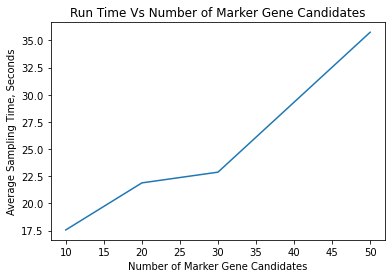

In [372]:
plt.plot(mgenes,marker_times)
plt.xlabel("Number of Marker Gene Candidates")
plt.ylabel("Average Sampling Time, Seconds")
plt.title("Run Time Vs Number of Marker Gene Candidates")
plt.show()